In [17]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
sys.path.append('..')

In [18]:
from cgol.generator.density_generator import DensityGenerator
from cgol.generator.uniform_density_generator import UniformDensityGenerator
from cgol.simulator.minimal_architecture_simulator import MinimalArchitectureSimulator
seed = 0

In [19]:
torch.use_deterministic_algorithms(True)

In [20]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.no_grad()

In [21]:
samples = 7500

batch_sizes = [
    samples, 
    samples, 
    samples
]
n_steps = 100

sizes = [
    (20,20), 
    (100,100), 
    (224,224)
]

generators = {
    'density 0.1': lambda batch_size, width, height: DensityGenerator(density=.1, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.2': lambda batch_size, width, height: DensityGenerator(density=.2, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.3': lambda batch_size, width, height: DensityGenerator(density=.3, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.4': lambda batch_size, width, height: DensityGenerator(density=.4, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.5': lambda batch_size, width, height: DensityGenerator(density=.5, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.6': lambda batch_size, width, height: DensityGenerator(density=.6, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.7': lambda batch_size, width, height: DensityGenerator(density=.7, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.8': lambda batch_size, width, height: DensityGenerator(density=.8, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'density 0.9': lambda batch_size, width, height: DensityGenerator(density=.9, device=device, width=width, height=height, batchsize=batch_size, seed=seed),
    'uniform': lambda batch_size, width, height: UniformDensityGenerator(device=device, width=width, height=height, batchsize=batch_size, seed=seed),
}

sim = MinimalArchitectureSimulator(device=device, dtype=torch.double)
DensityGenerator(density=.1, device=device, width=32, height=16, batchsize=8, seed=seed)

In [ ]:
# sizes X generators X steps X min, max, avg, med, var
def get_stats(img_batch: torch.Tensor) -> np.ndarray:
    sums = img_batch.sum(dim=(1,2),dtype=torch.double).detach()
    return np.array([
        sums.min().to('cpu'),
        sums.max().to('cpu'), 
        sums.mean(dtype=torch.float).to('cpu'),
        sums.median().to('cpu'),
        sums.var().to('cpu')
    ])

In [23]:
get_stats(torch.tensor([
    [[0,1,1],[0,1,1],[0,1,1],[0,1,1]],
    [[0,1,1],[0,1,1],[0,1,1],[0,1,0]],
    [[0,1,1],[0,1,1],[0,1,1],[0,0,0]],
]))

array([6., 8., 7., 7., 1.])

In [24]:
# sizes X generators X steps X min, max, avg, med, var
stats = np.zeros((
        len(sizes),
        len(generators),
        n_steps+1,
        5
    ),dtype='float')

if False:
    with torch.no_grad():
        for i, size, batch_size in zip(range(len(sizes)), sizes, batch_sizes):
            for j, (generator_name, get_generator) in zip(range(len(generators)), generators.items()):
                print(size, generator_name, batch_size)
                generator = get_generator(batch_size, size[0], size[1])
                ims = generator.generateBatchTensor()
                stats[i, j, 0] = get_stats(ims)
                for step in range(n_steps):
                    ims = sim.stepBatchTensor(ims)
                    stats[i, j, step+1] = get_stats(ims)




In [25]:
if False:
    with open('generator-simple-stats.pkl', 'wb') as file:
        pkl.dump(stats, file)
if True:
    with open('generator-simple-stats.pkl', 'rb') as file:
        stats = pkl.load(file)

In [26]:
np.array([1,2,3,4,5])[:4]

array([1, 2, 3, 4])

(30, 101, 5)
(3, 10, 101, 5)
(3, 10, 101, 5)


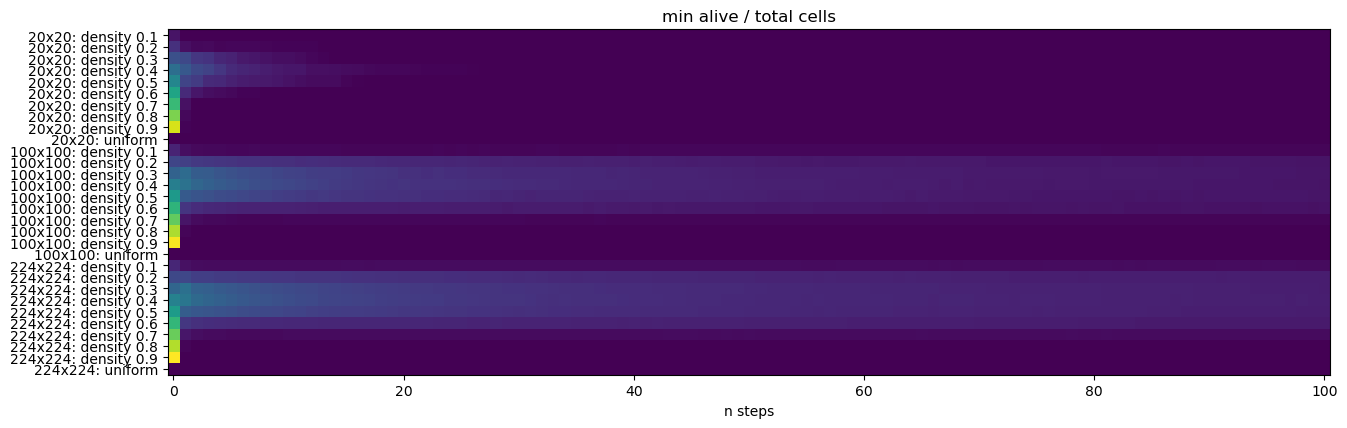

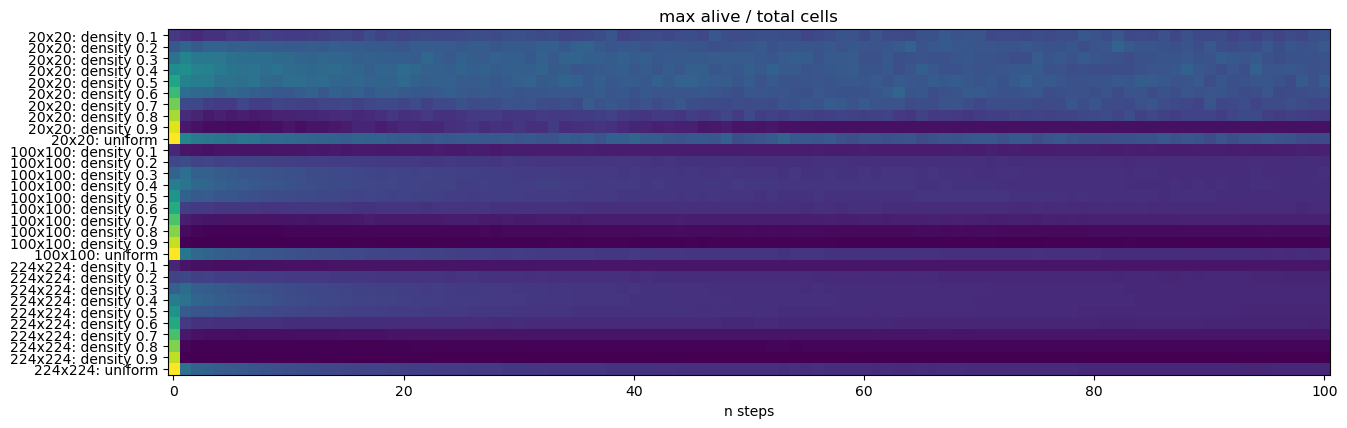

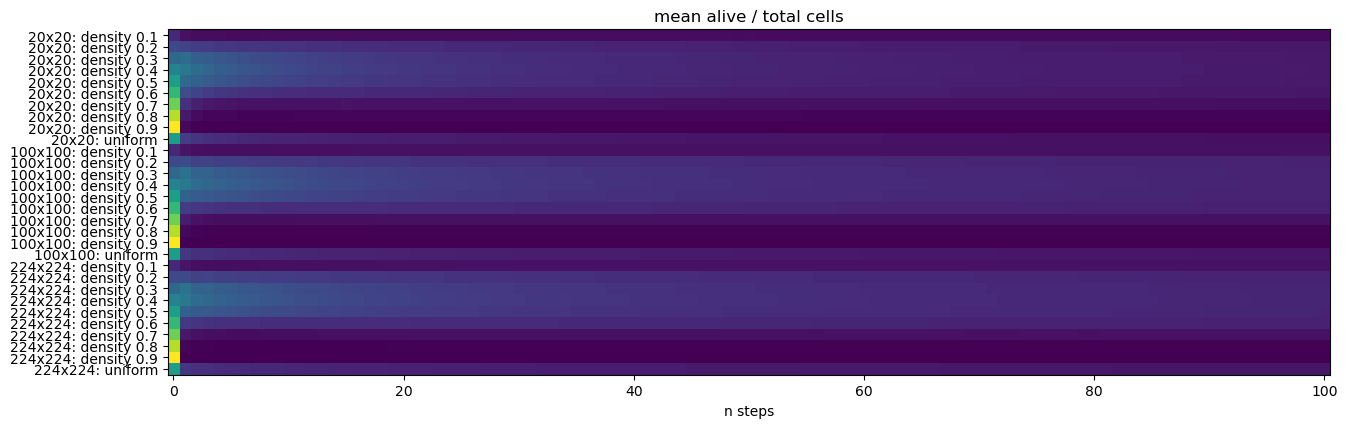

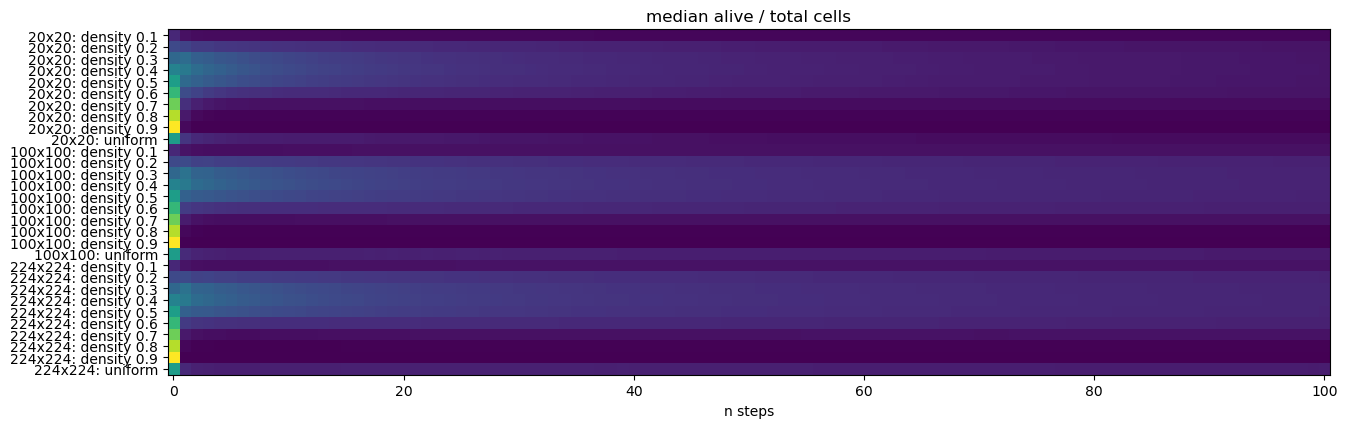

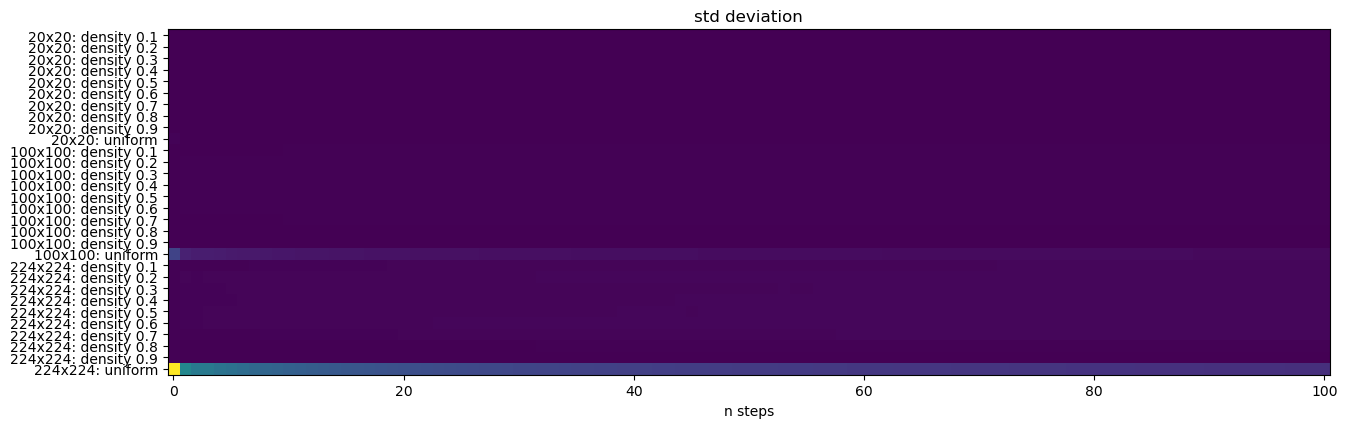

In [27]:
stats_norm = stats.copy()
#[sizes,generator,steps,stats]
stats_norm[0,:,:,:4] /= (20*20)
stats_norm[1,:,:,:4] /= (100*100)
stats_norm[2,:,:,:4] /= (224*224)
flat_stats = stats_norm.reshape(-1, *stats_norm.shape[2:])
print(flat_stats.shape)
print(stats.shape)
print(stats_norm.shape)

y_labels = []
for size in sizes:
    for generator_name in generators.keys():
        y_labels.append(f'{size[0]}x{size[0]}: {generator_name}')

plt.figure(figsize=(15,10))
plt.imshow(flat_stats[:,:,0])
plt.title('min alive / total cells')
plt.xlabel('n steps')
plt.yticks(range(len(y_labels)), y_labels)
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(flat_stats[:,:,1])
plt.title('max alive / total cells')
plt.xlabel('n steps')
plt.yticks(range(len(y_labels)), y_labels)
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(flat_stats[:,:,2])
plt.title('mean alive / total cells')
plt.xlabel('n steps')
plt.yticks(range(len(y_labels)), y_labels)
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(flat_stats[:,:,3])
plt.title('median alive / total cells')
plt.xlabel('n steps')
plt.yticks(range(len(y_labels)), y_labels)
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(flat_stats[:,:,4]**(1/2))
plt.title('std deviation')
plt.xlabel('n steps')
plt.yticks(range(len(y_labels)), y_labels)
plt.show()

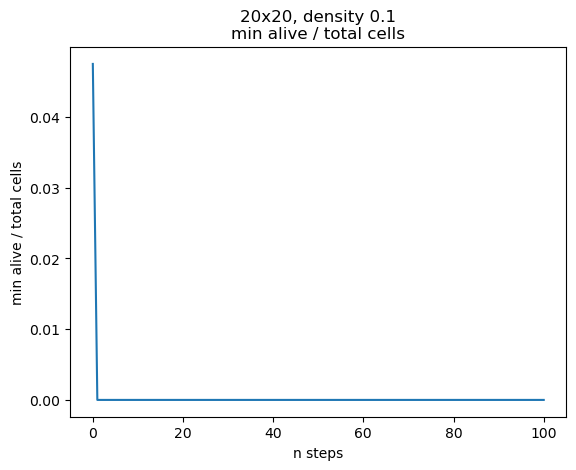

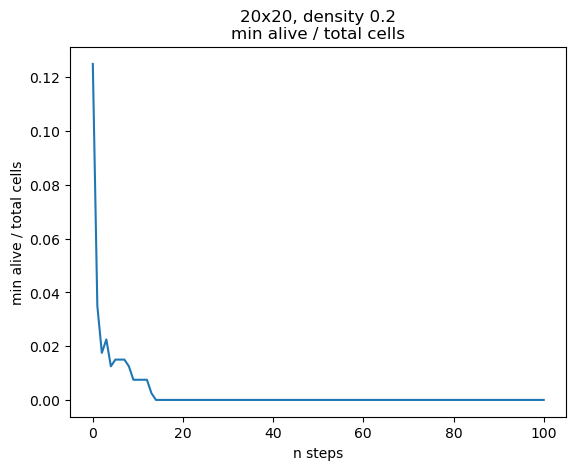

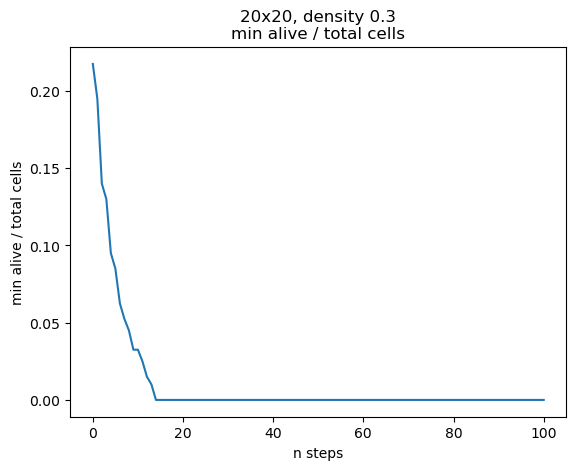

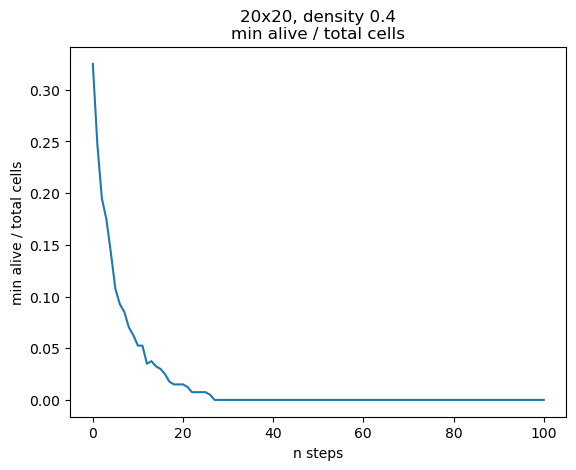

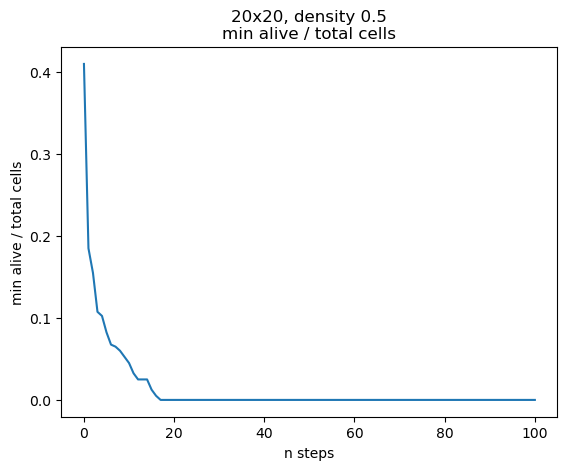

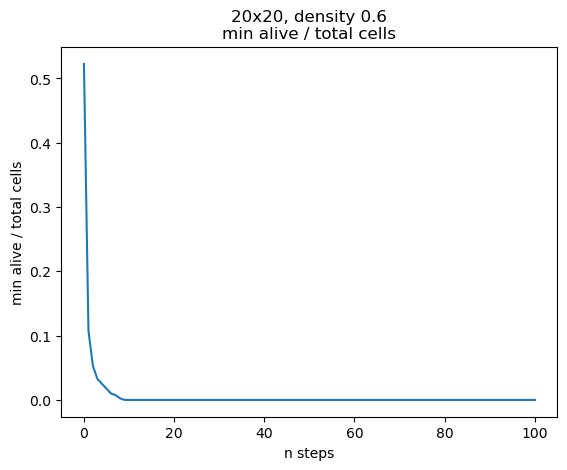

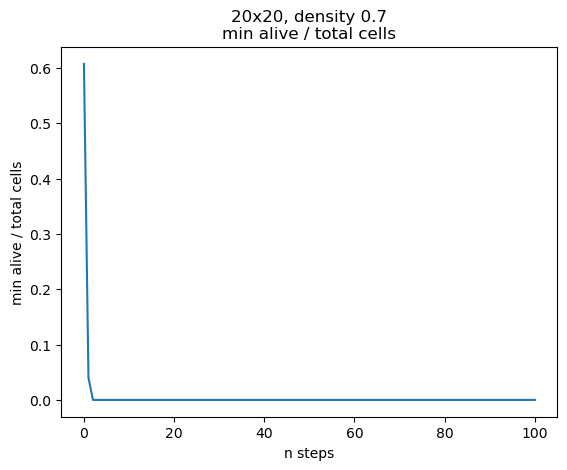

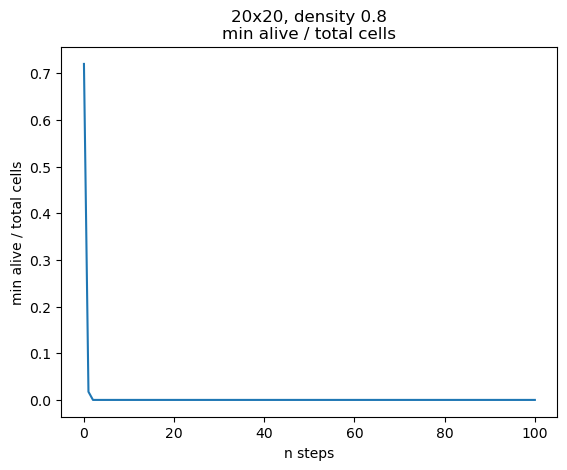

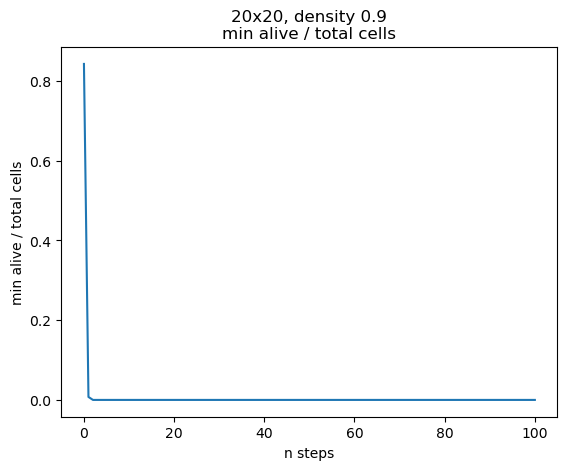

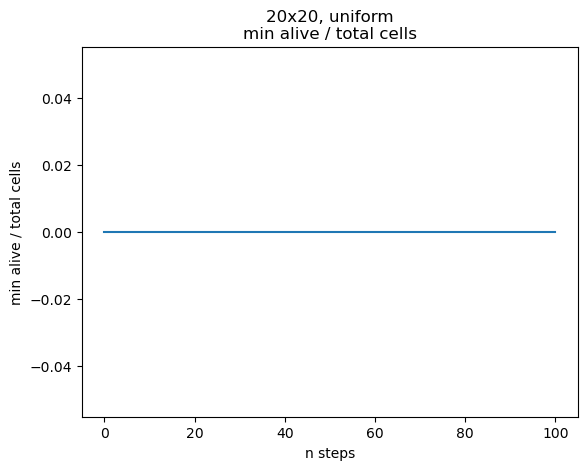

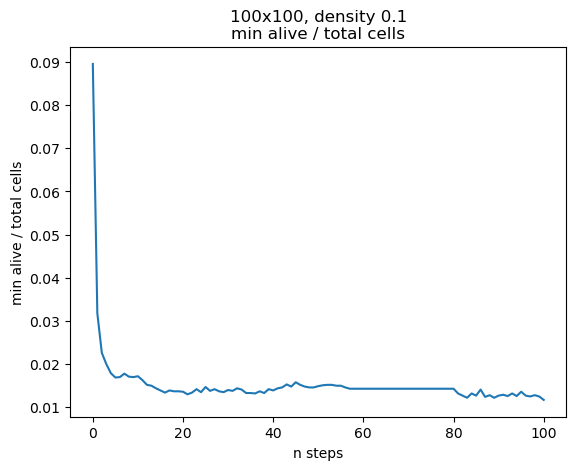

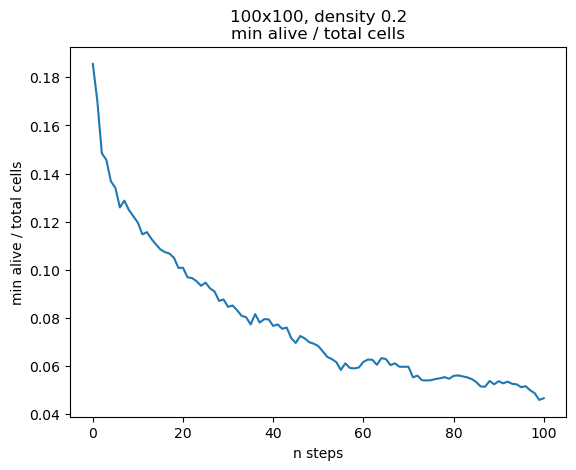

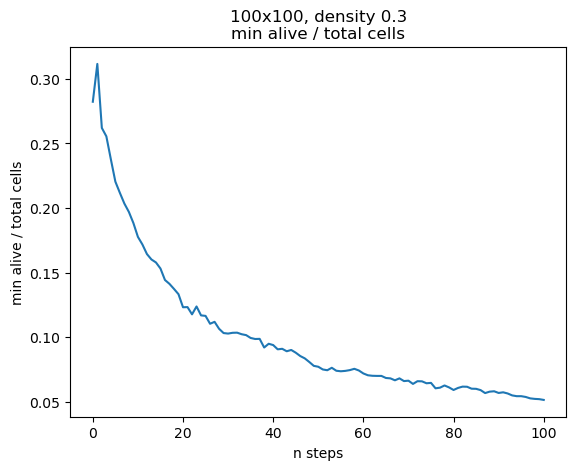

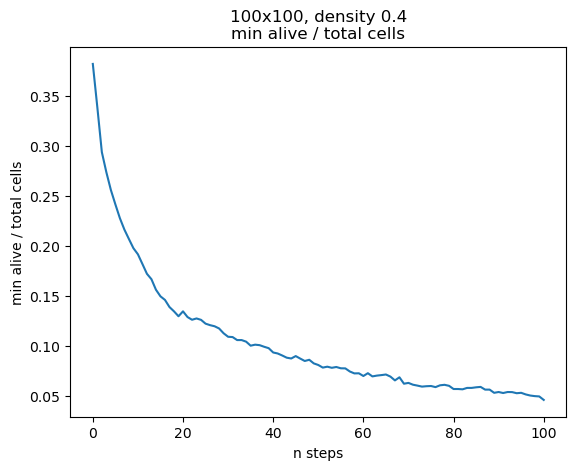

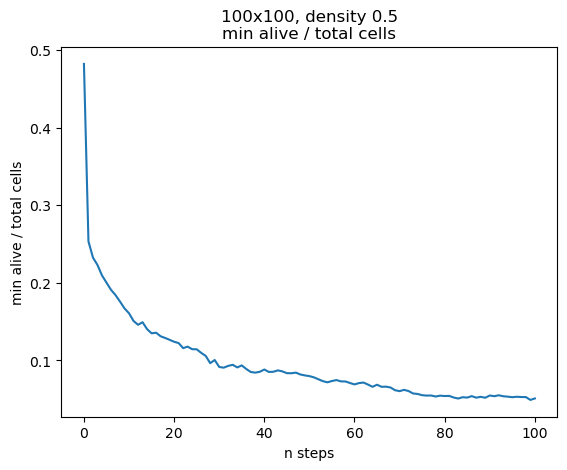

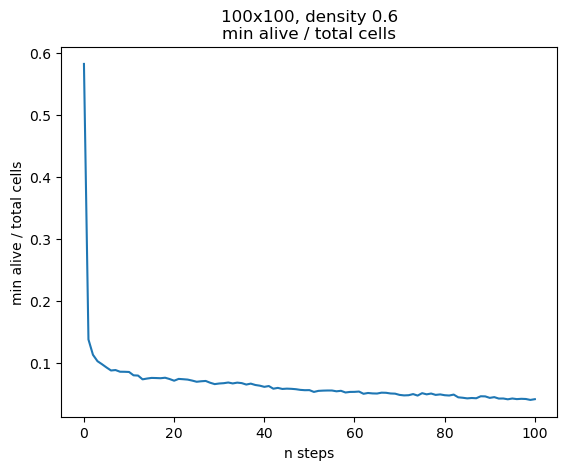

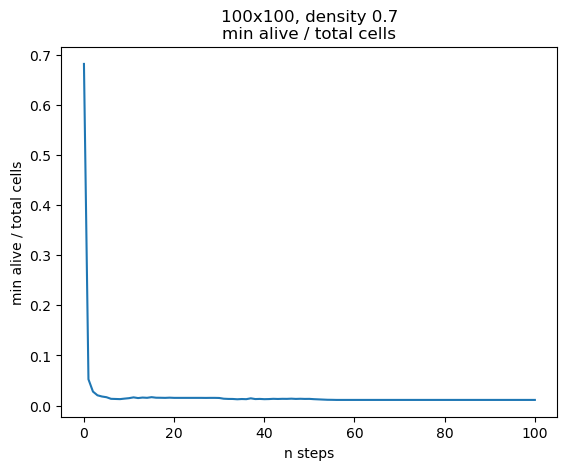

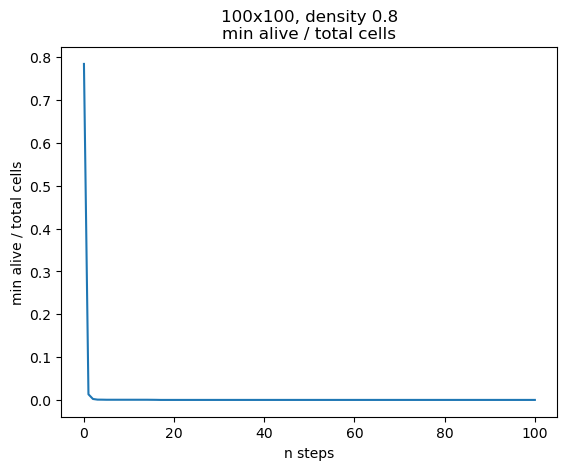

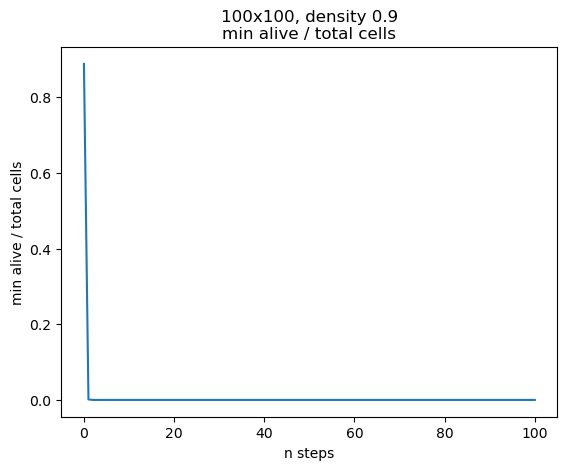

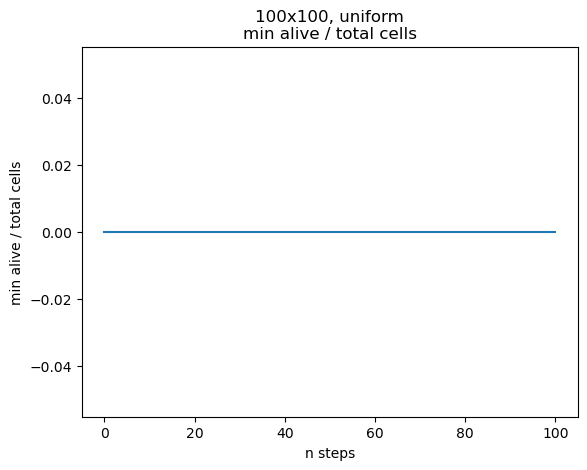

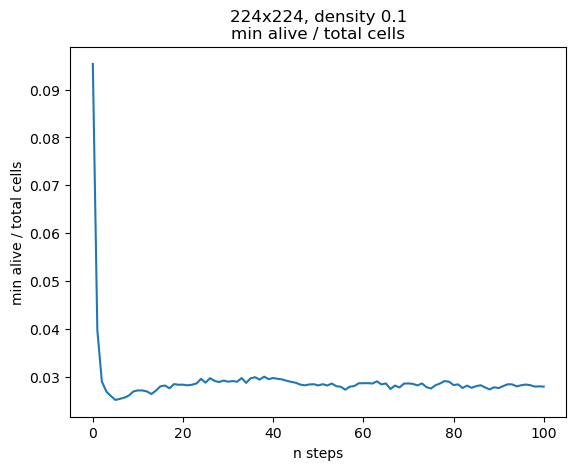

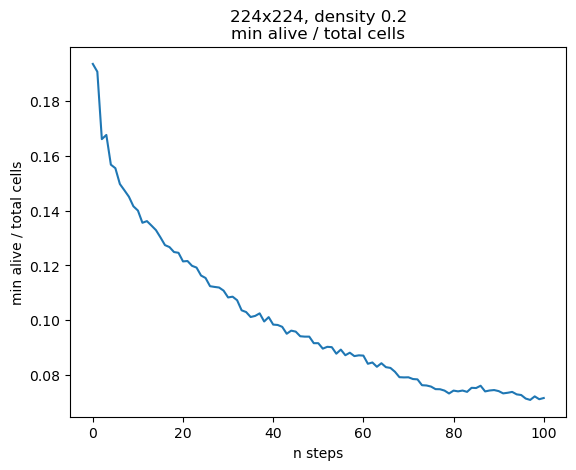

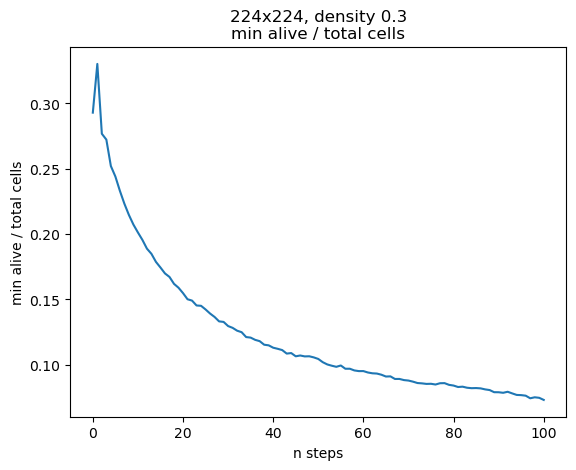

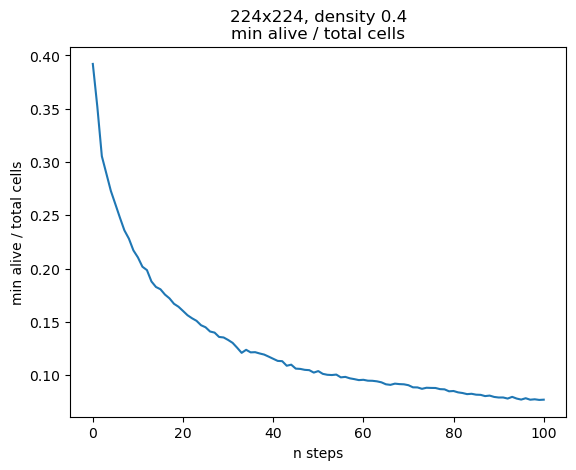

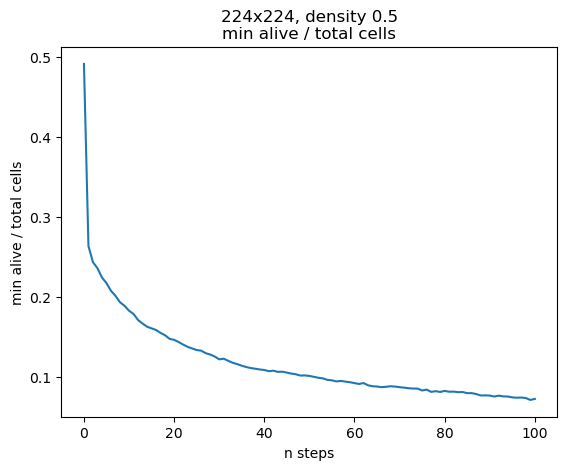

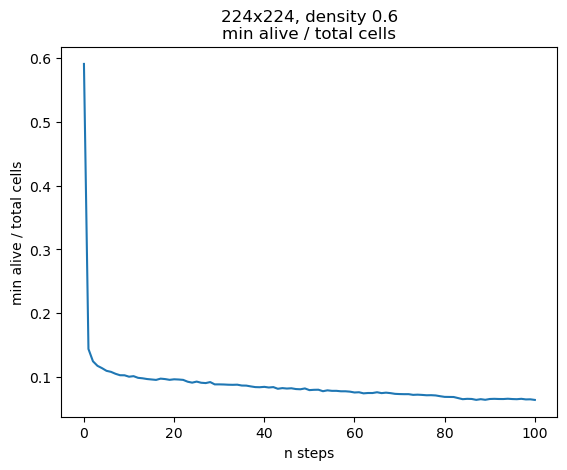

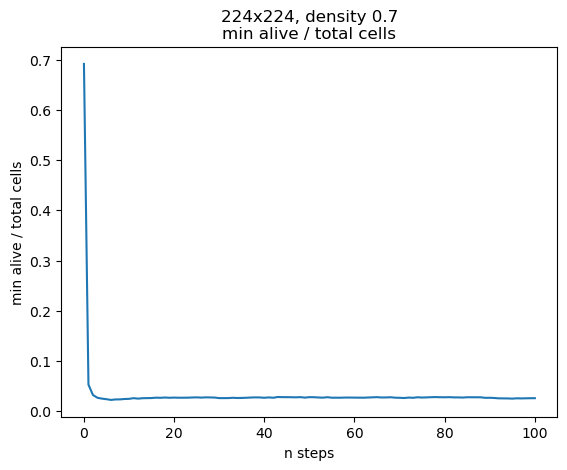

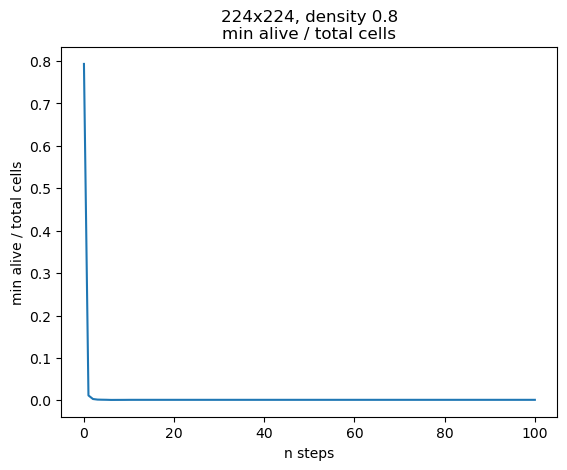

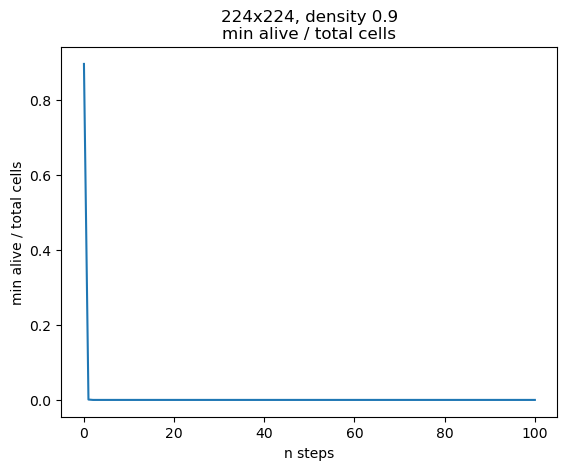

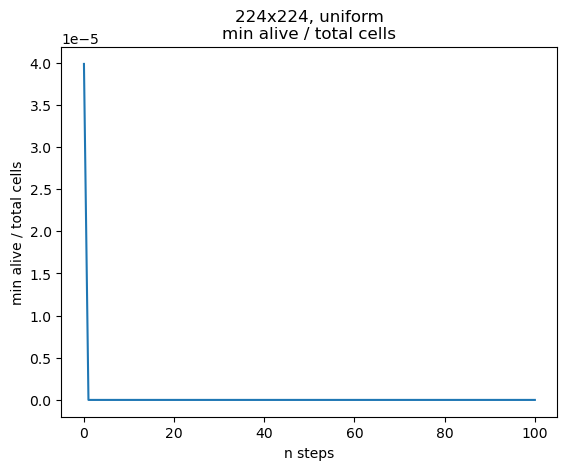

In [28]:
for i, size in enumerate(sizes):
    for j, generator_name in enumerate(generators.keys()):
        stat_name = 'min alive / total cells'
        plt.figure()
        plt.title(f'{size[0]}x{size[1]}, {generator_name}\n{stat_name}')
        plt.plot(range(stats_norm.shape[2]), stats_norm[i,j,:,0])
        plt.xlabel('n steps')
        plt.ylabel(stat_name)
        plt.show()

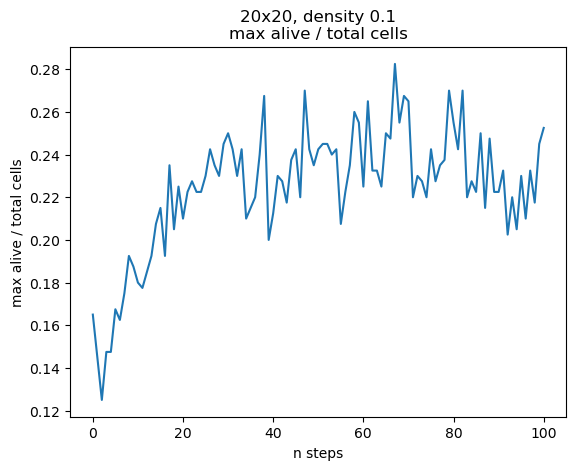

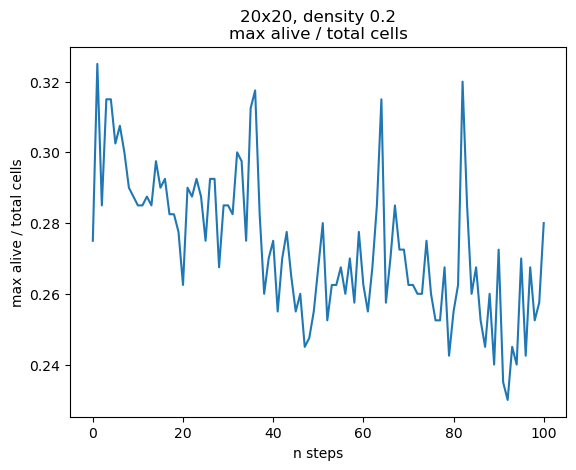

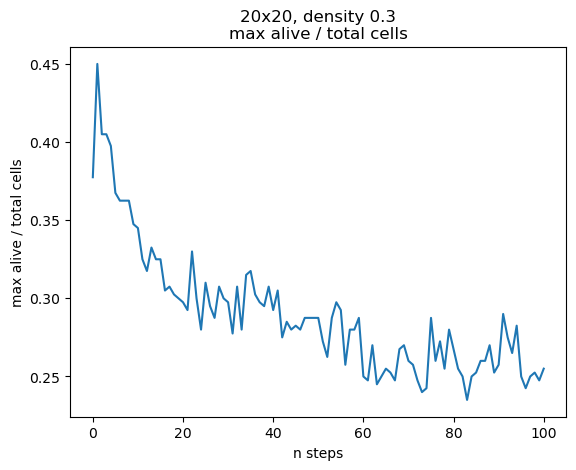

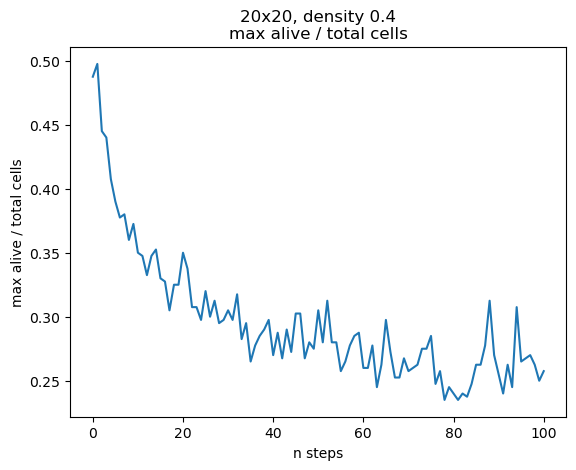

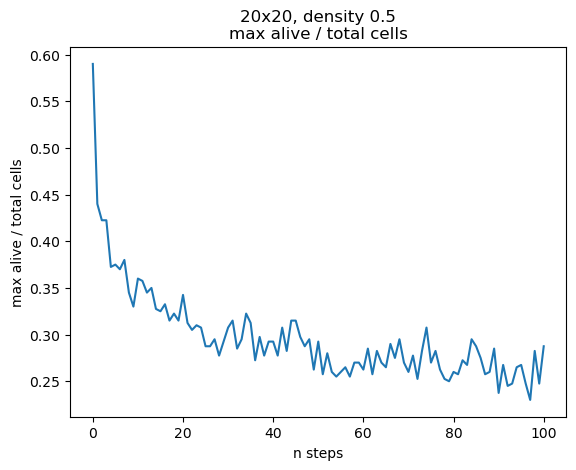

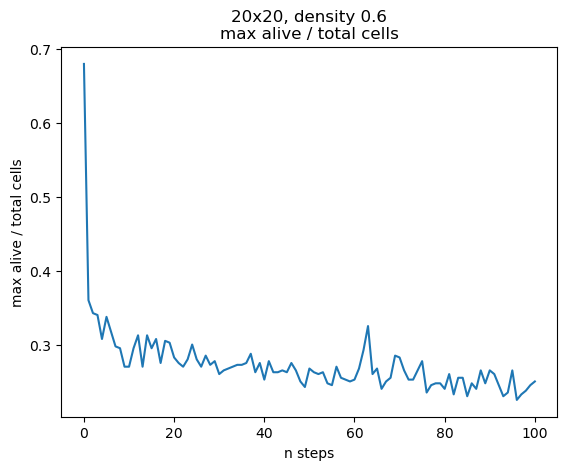

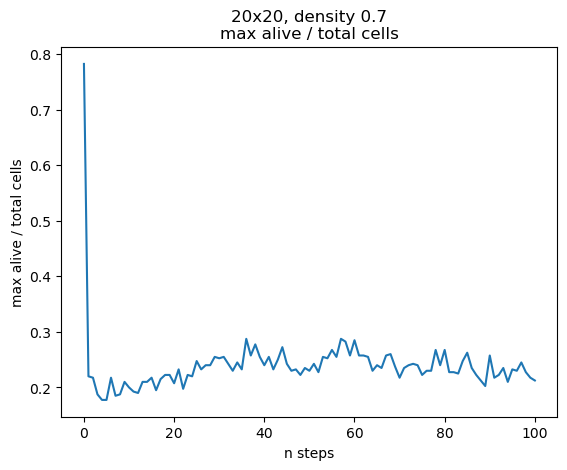

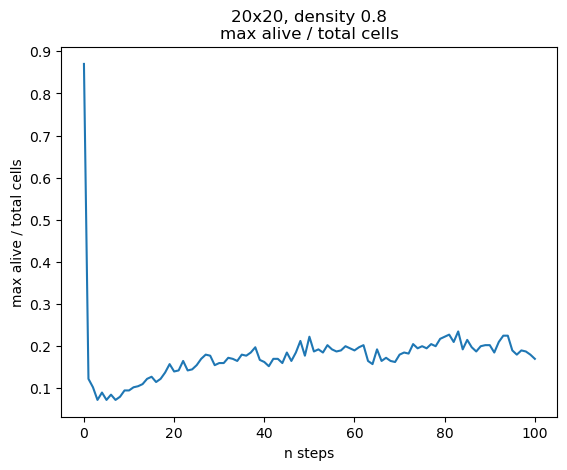

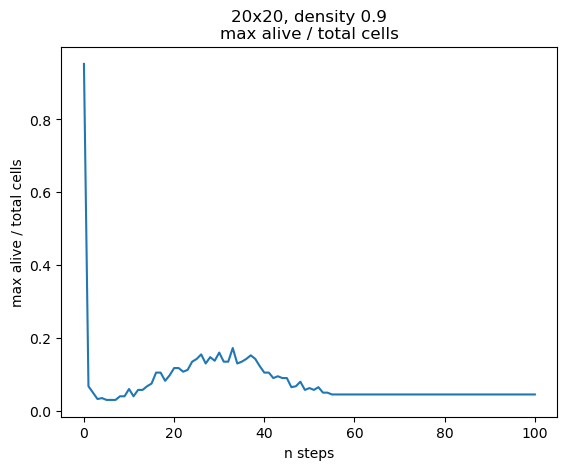

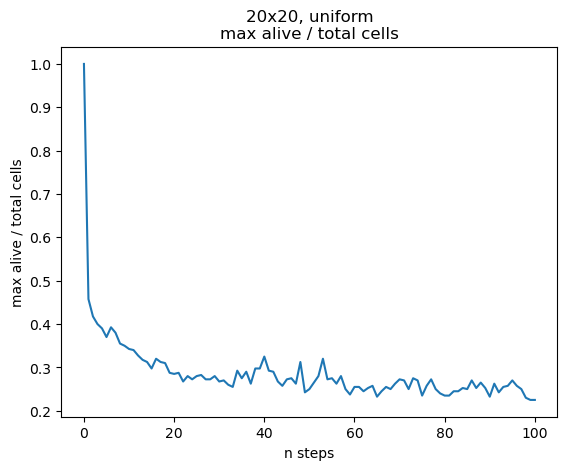

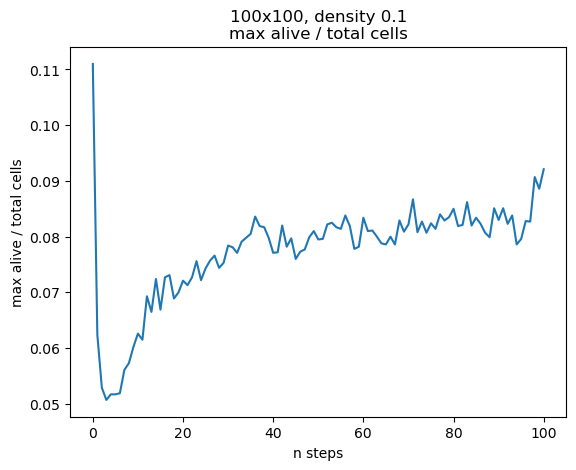

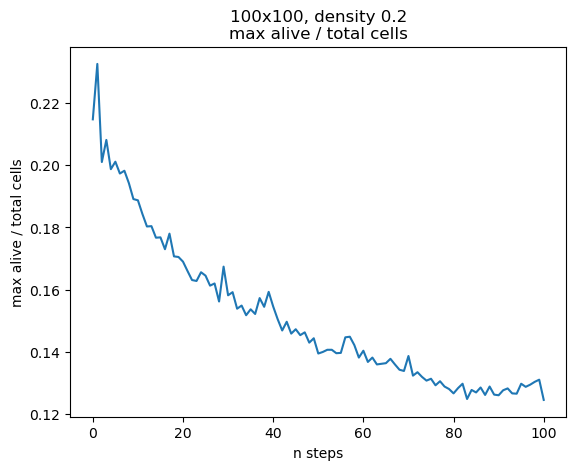

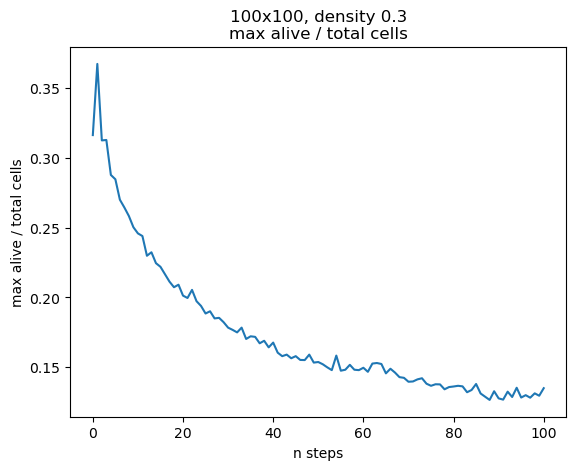

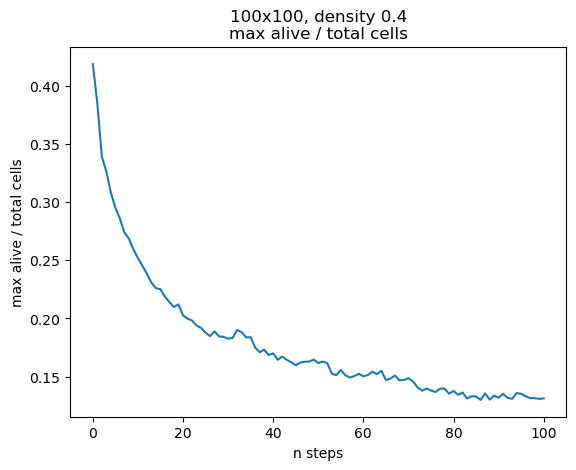

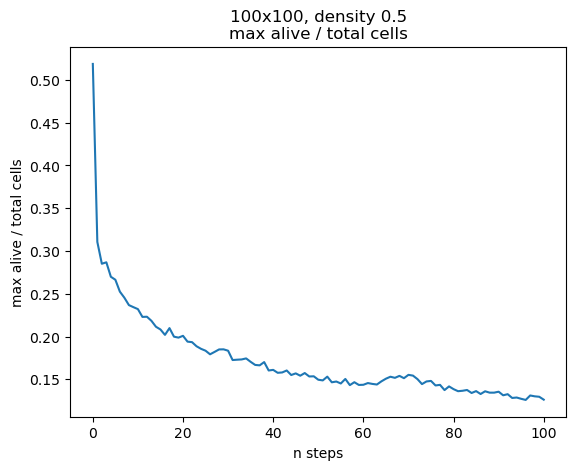

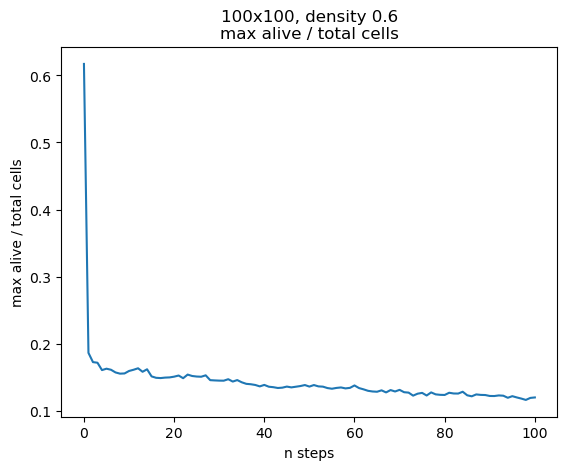

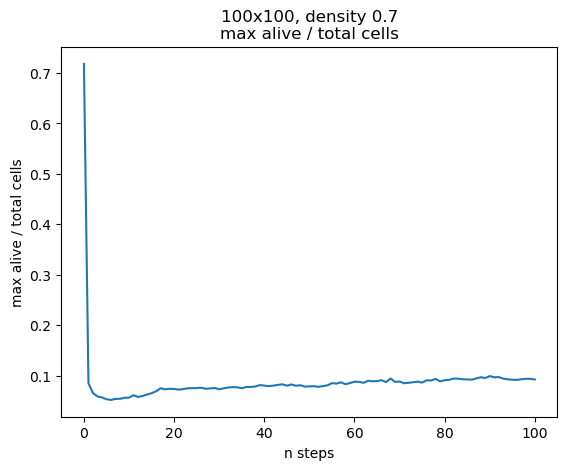

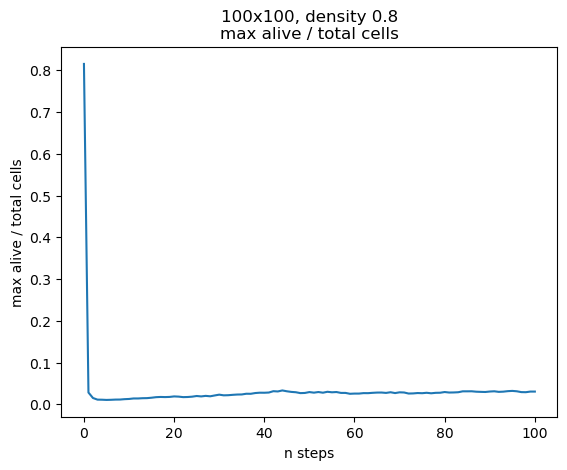

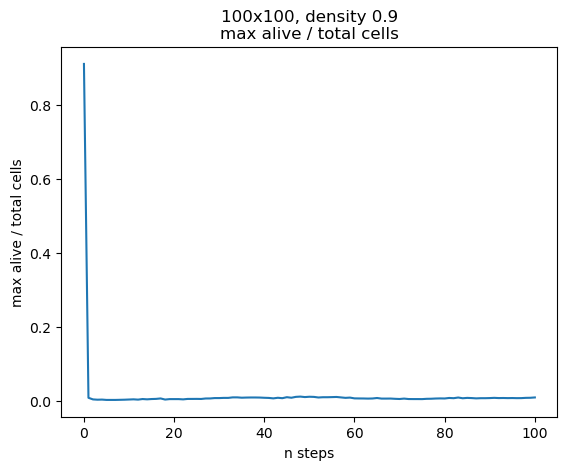

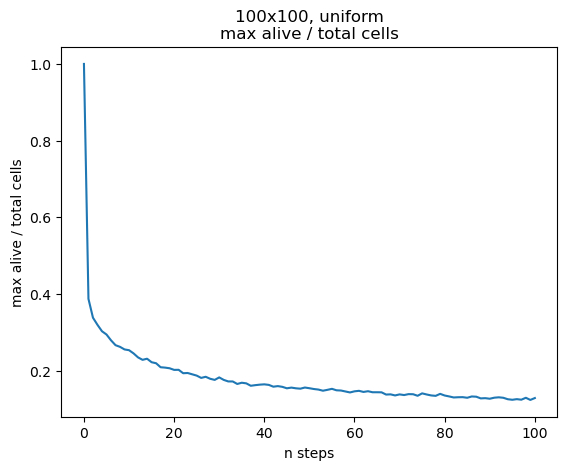

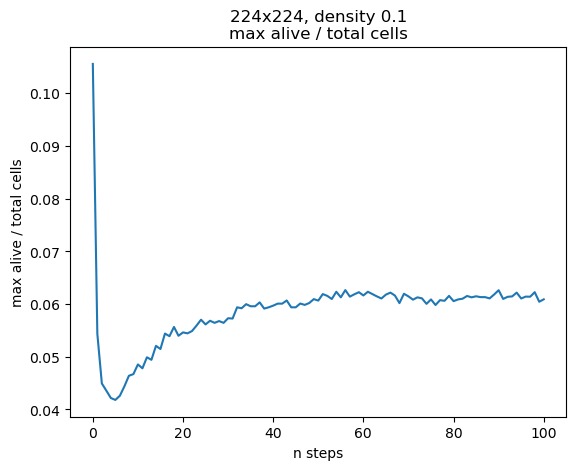

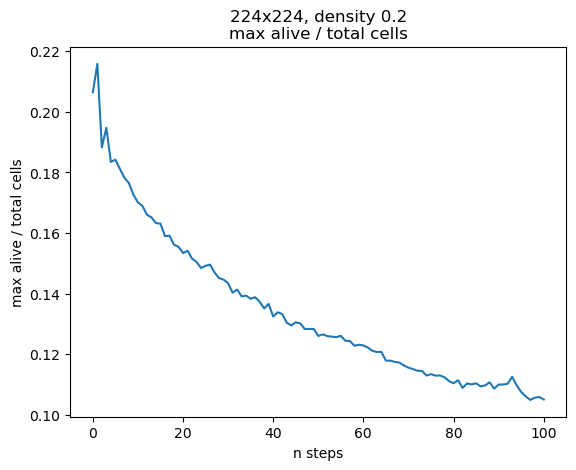

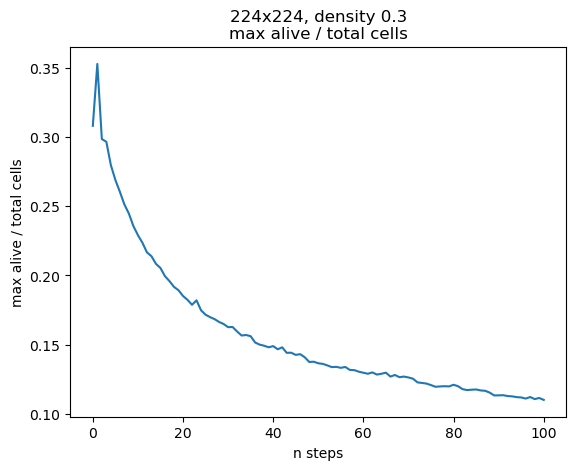

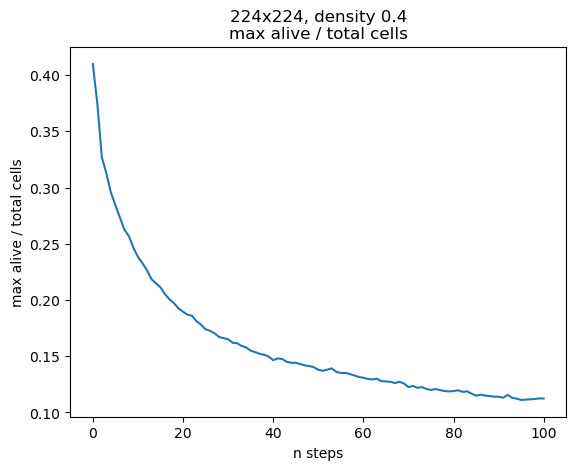

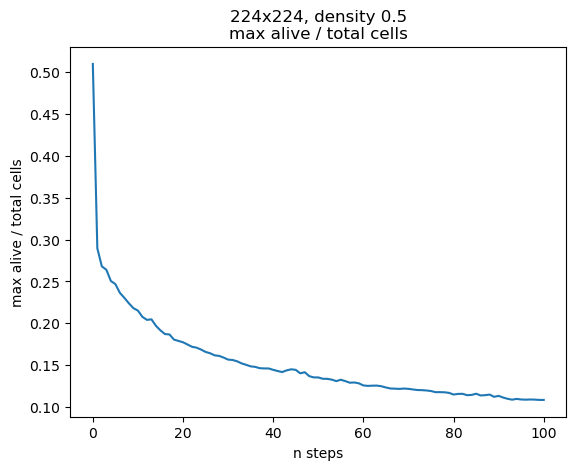

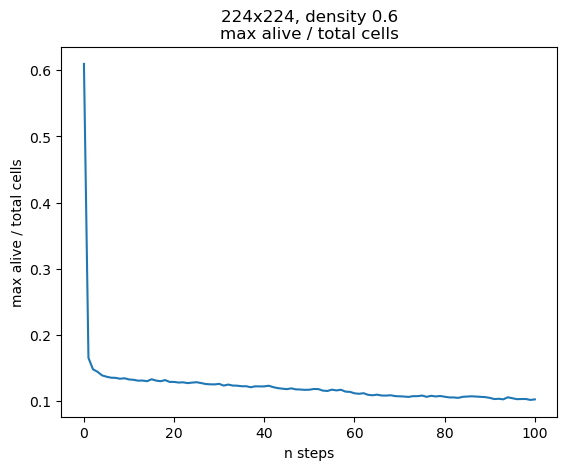

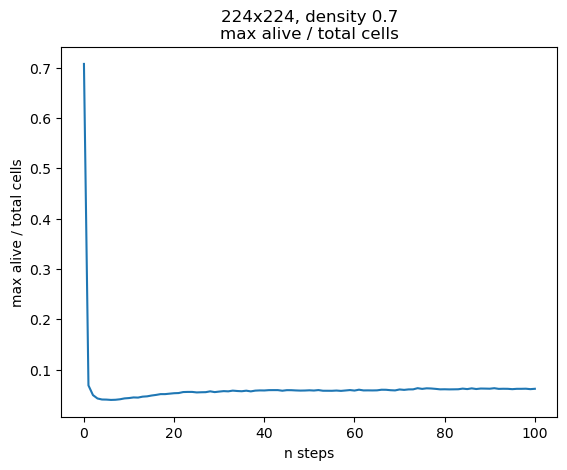

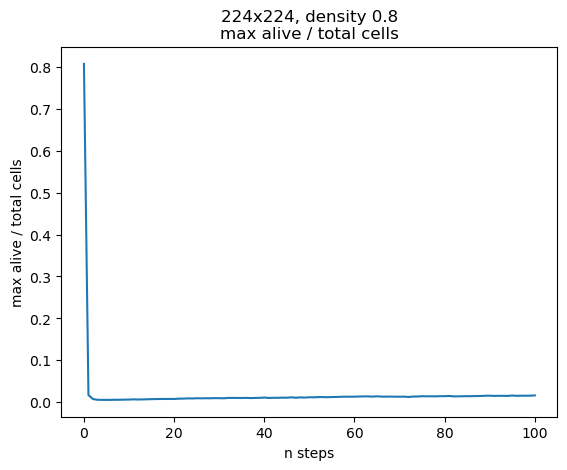

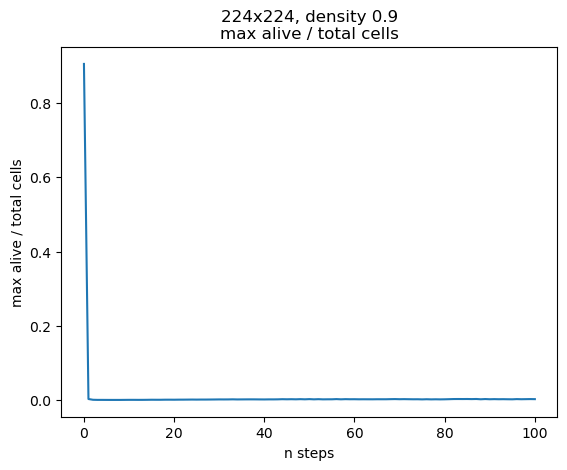

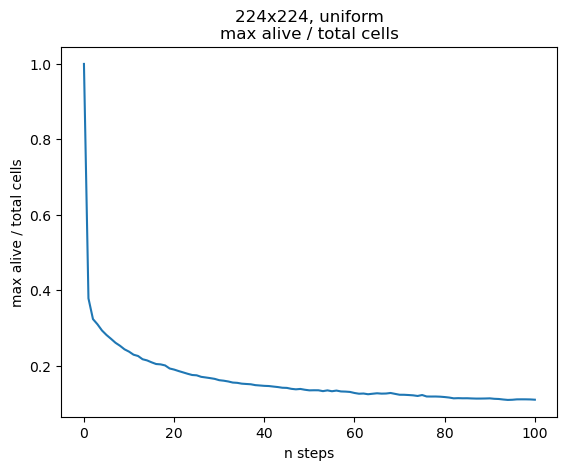

In [29]:
for i, size in enumerate(sizes):
    for j, generator_name in enumerate(generators.keys()):
        stat_name = 'max alive / total cells'
        plt.figure()
        plt.title(f'{size[0]}x{size[1]}, {generator_name}\n{stat_name}')
        plt.plot(range(stats_norm.shape[2]), stats_norm[i,j,:,1])
        plt.xlabel('n steps')
        plt.ylabel(stat_name)
        plt.show()

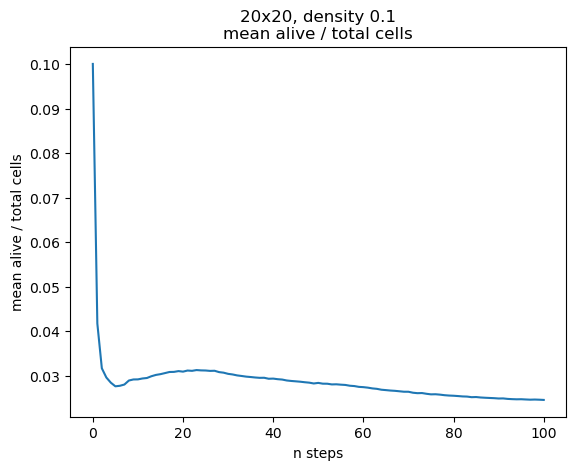

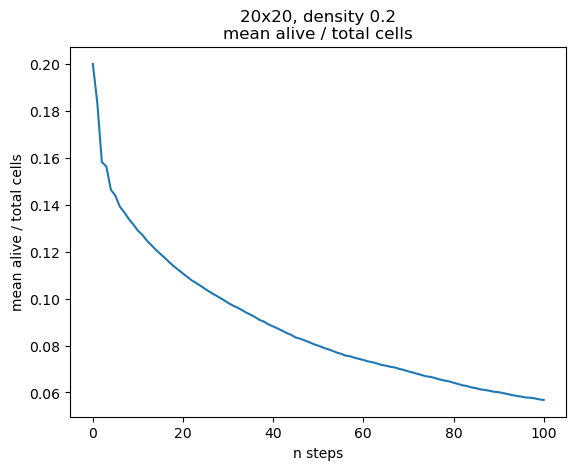

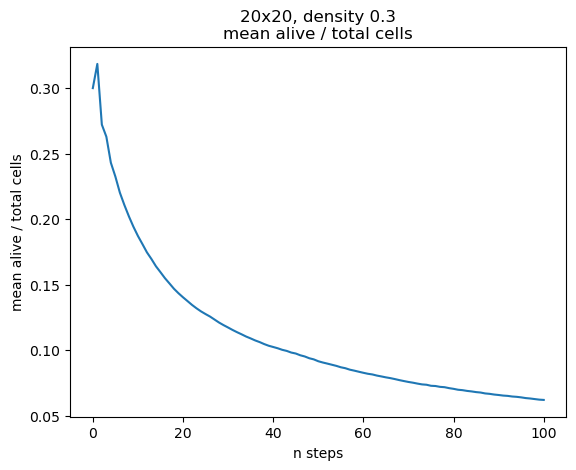

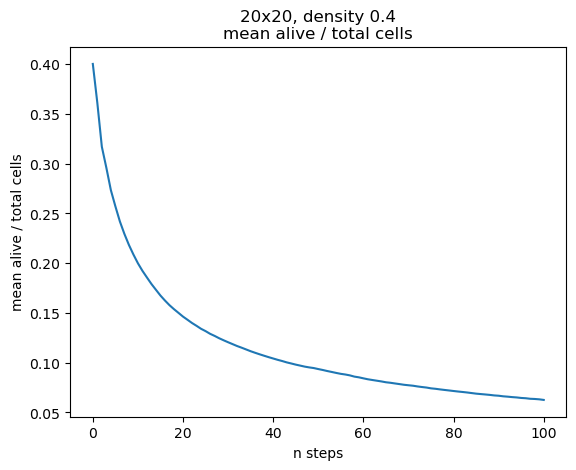

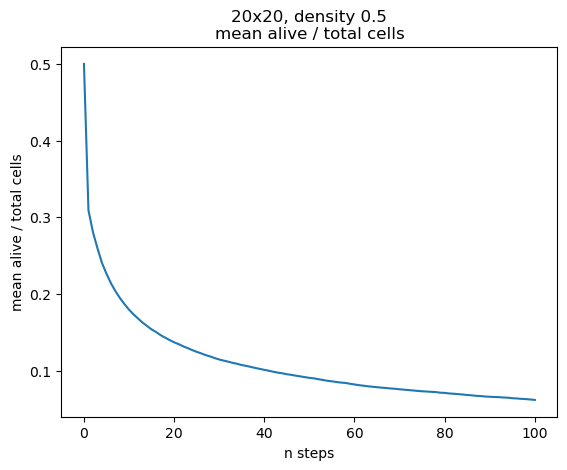

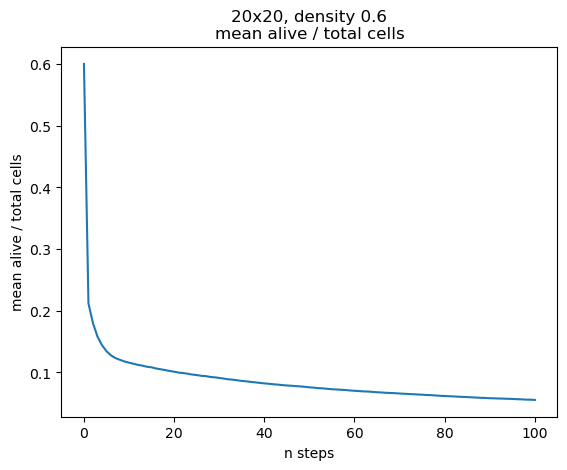

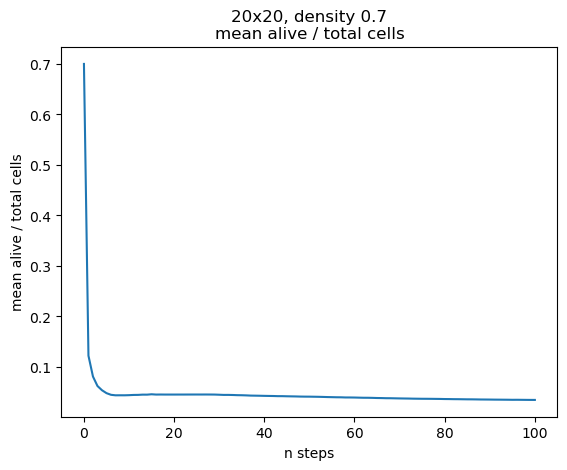

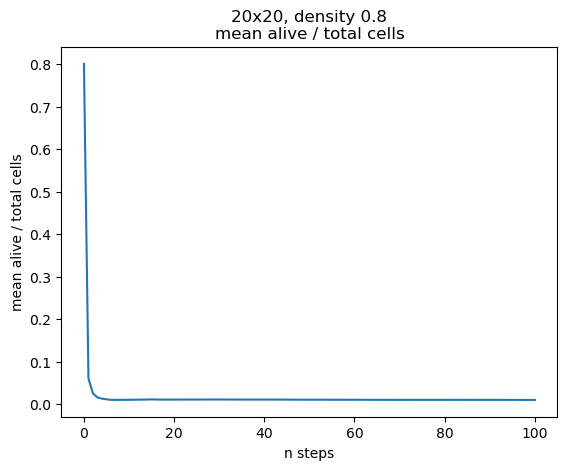

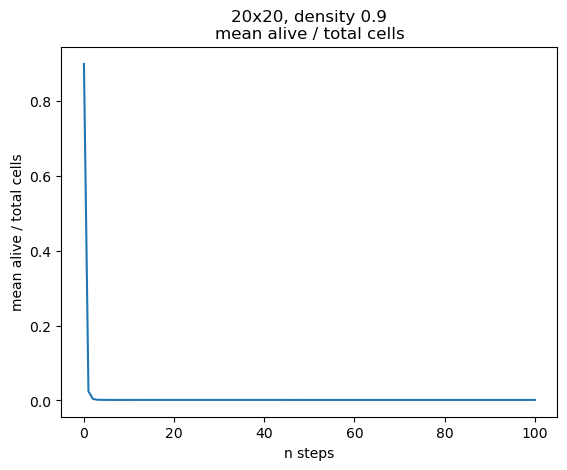

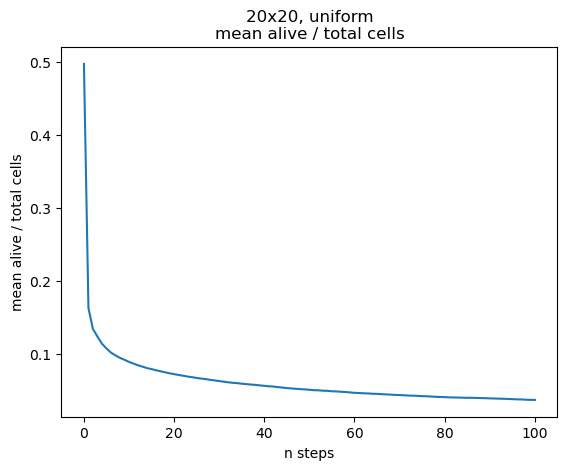

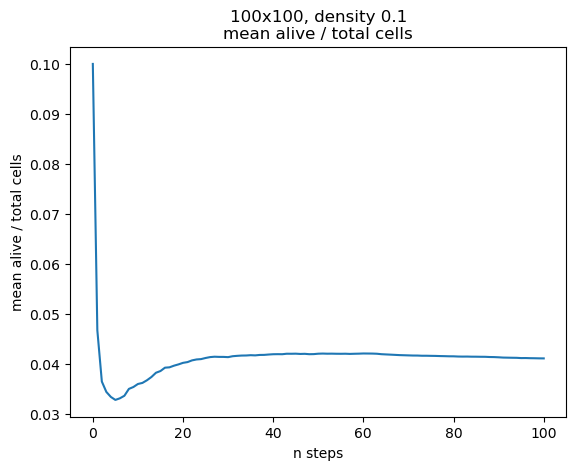

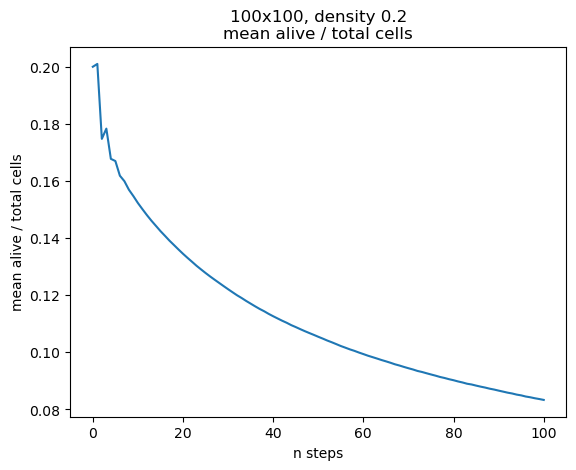

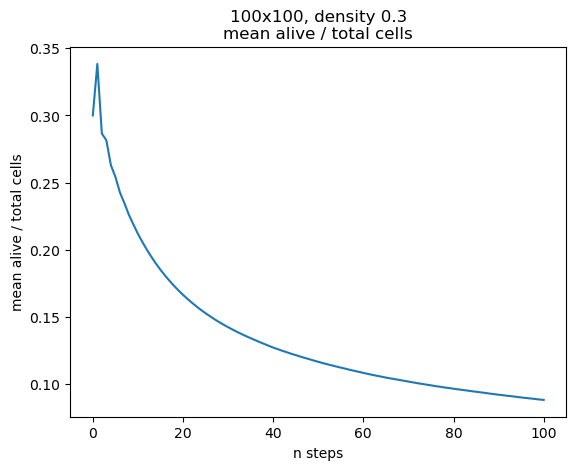

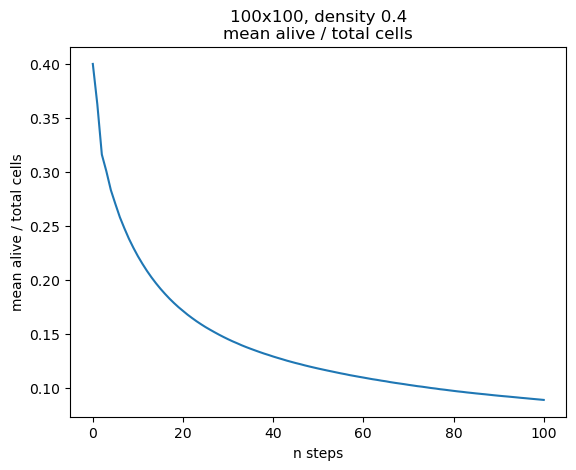

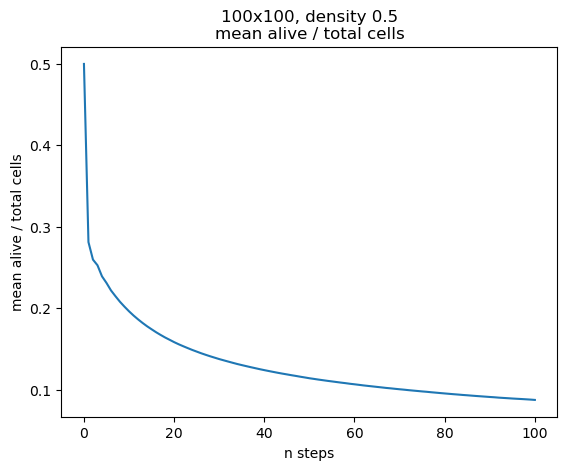

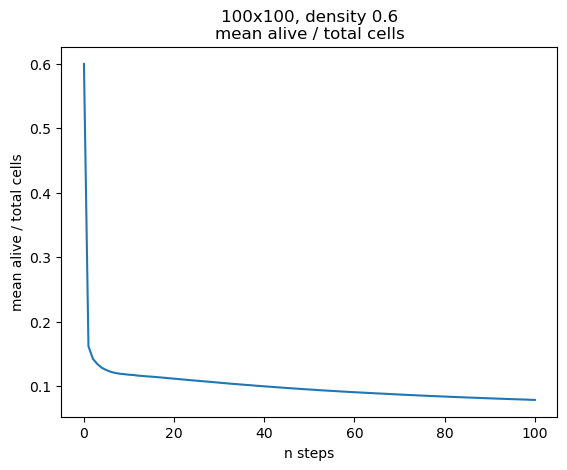

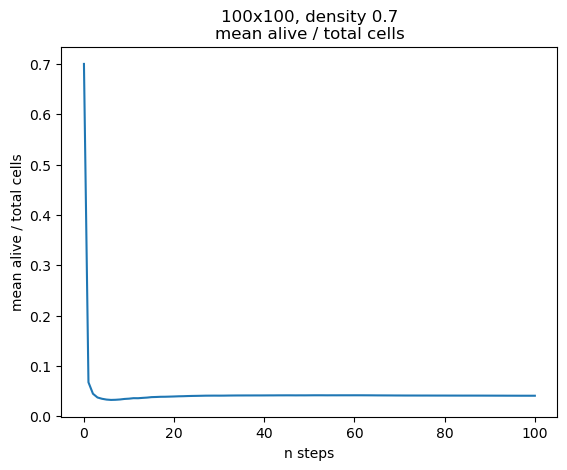

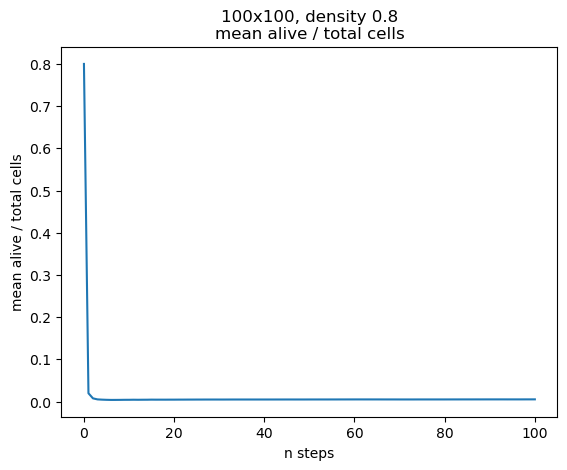

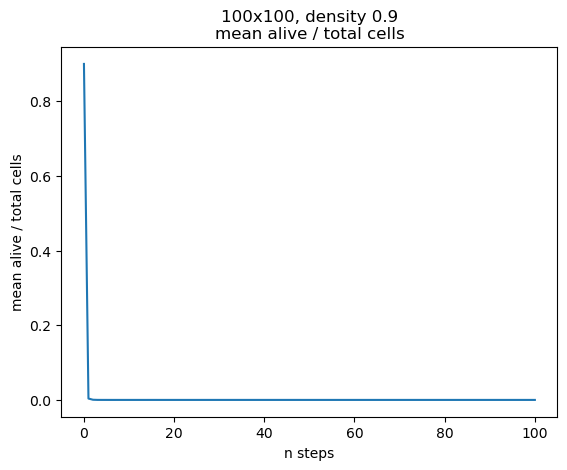

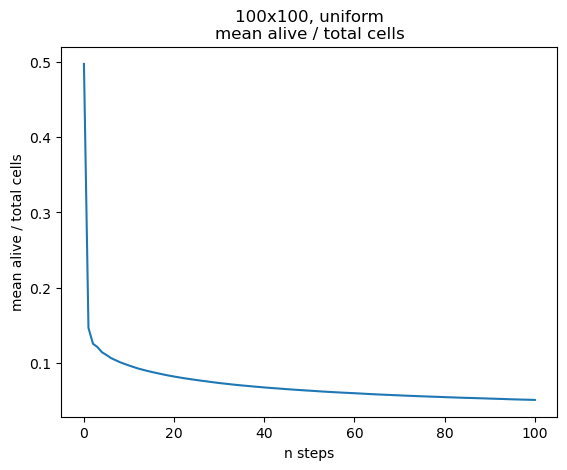

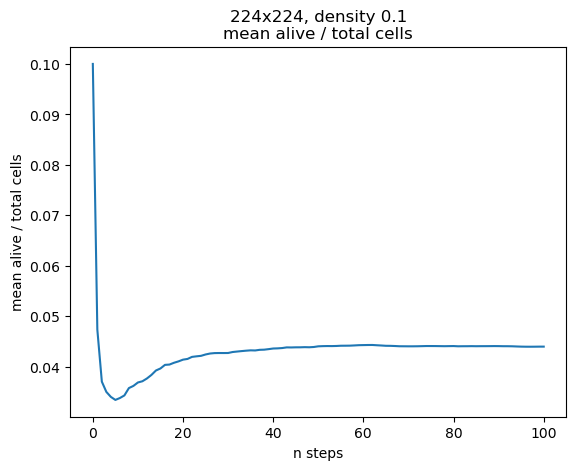

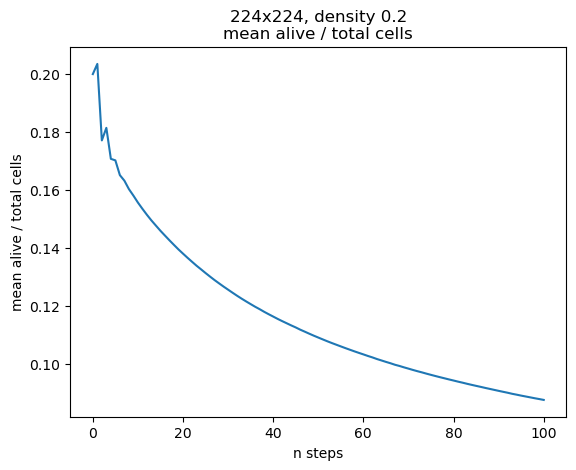

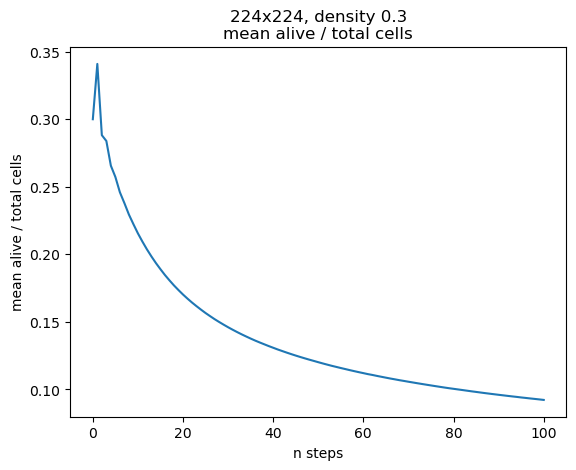

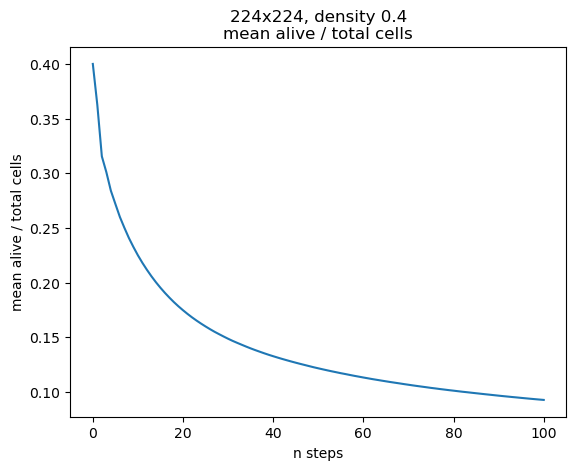

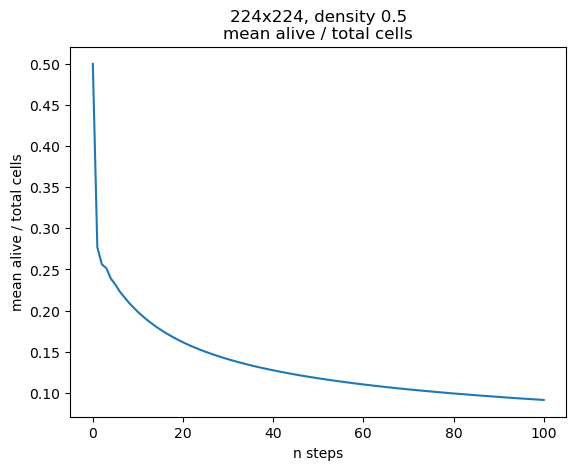

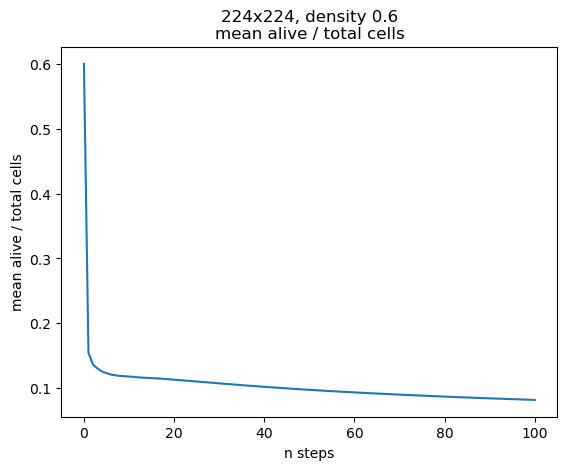

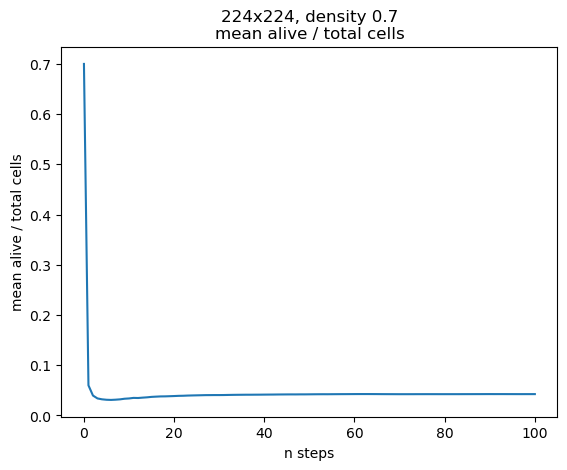

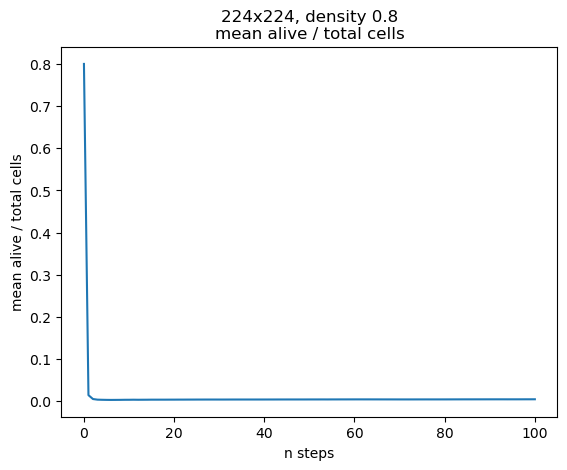

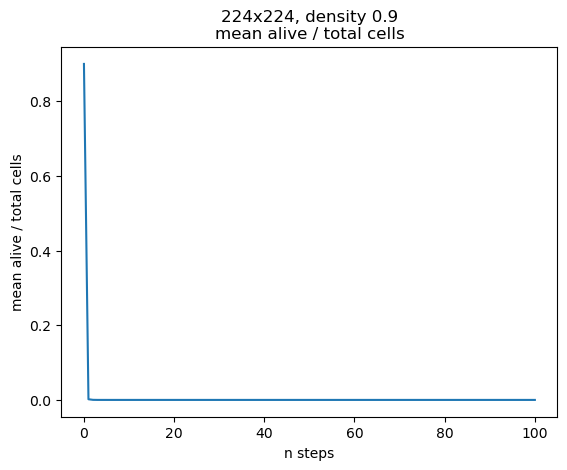

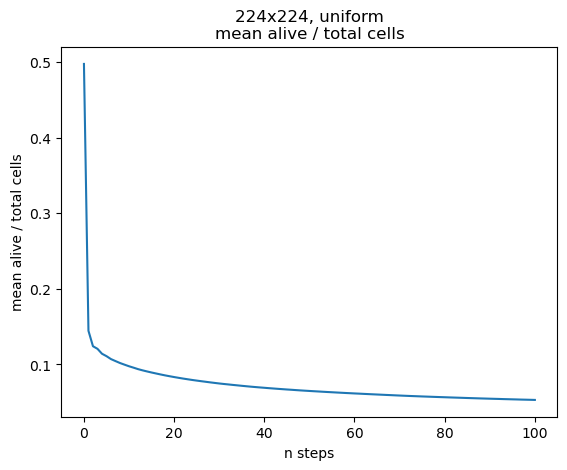

In [30]:
for i, size in enumerate(sizes):
    for j, generator_name in enumerate(generators.keys()):
        stat_name = 'mean alive / total cells'
        plt.figure()
        plt.title(f'{size[0]}x{size[1]}, {generator_name}\n{stat_name}')
        plt.plot(range(stats_norm.shape[2]), stats_norm[i,j,:,2])
        plt.xlabel('n steps')
        plt.ylabel(stat_name)
        plt.show()

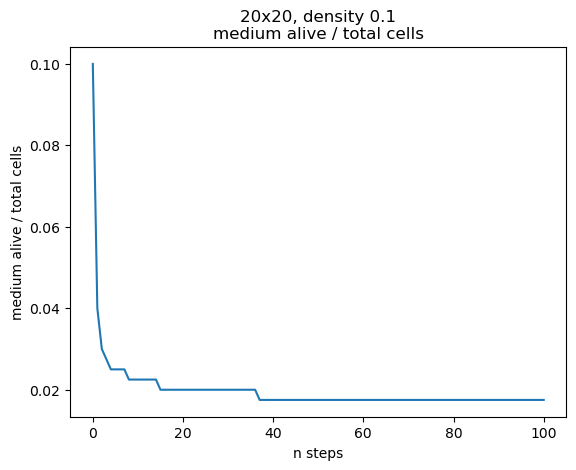

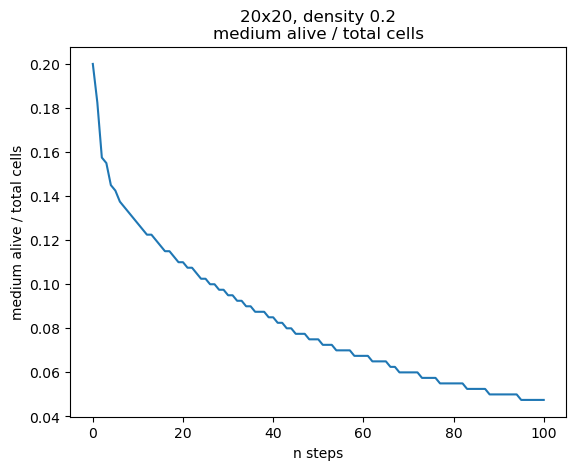

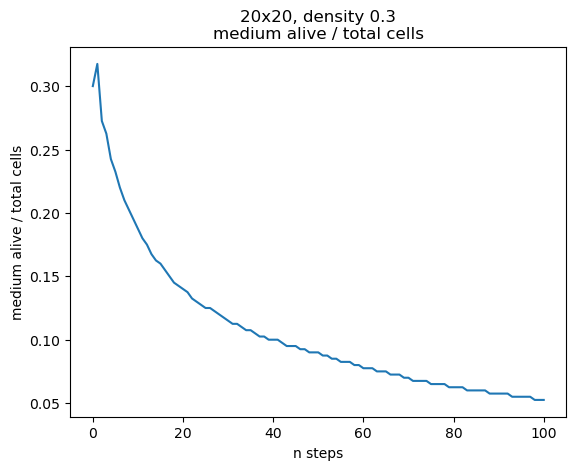

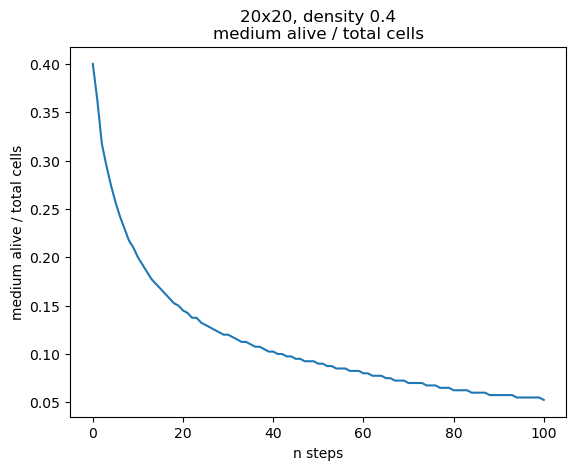

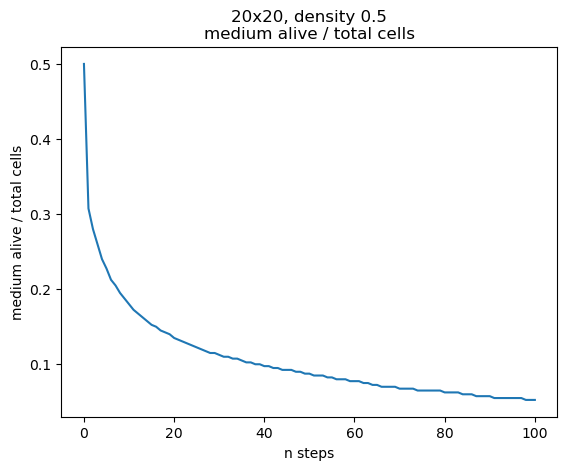

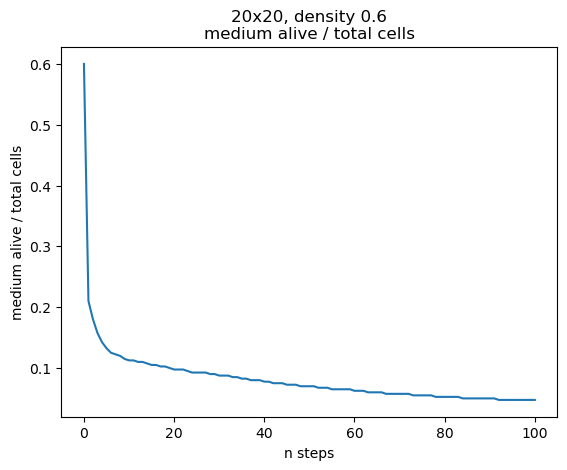

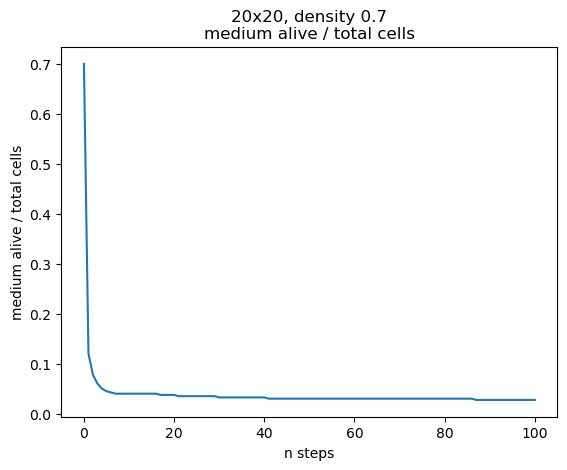

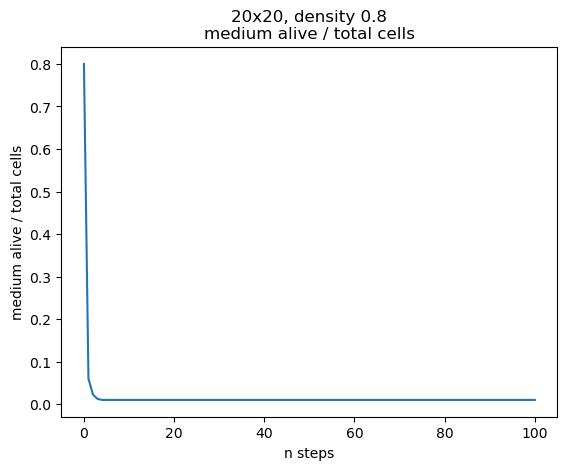

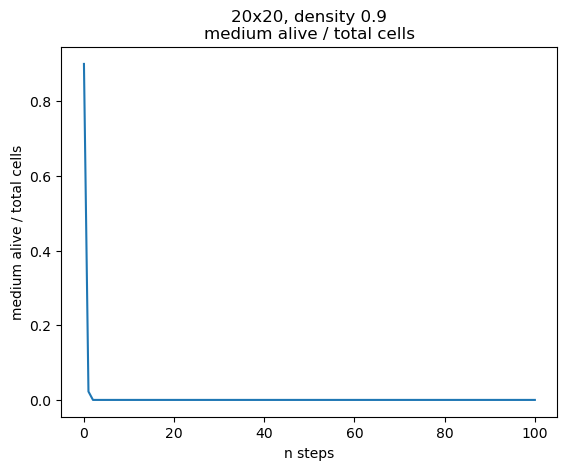

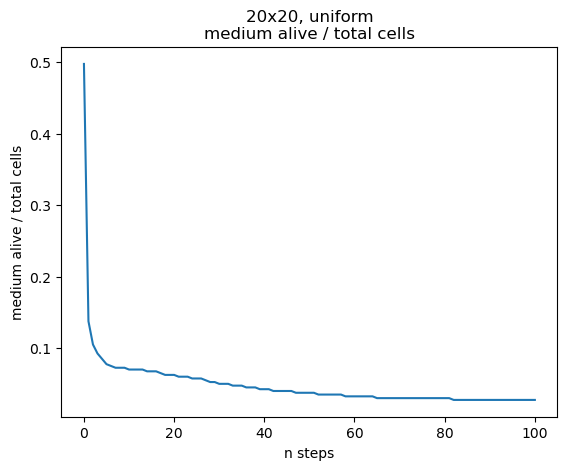

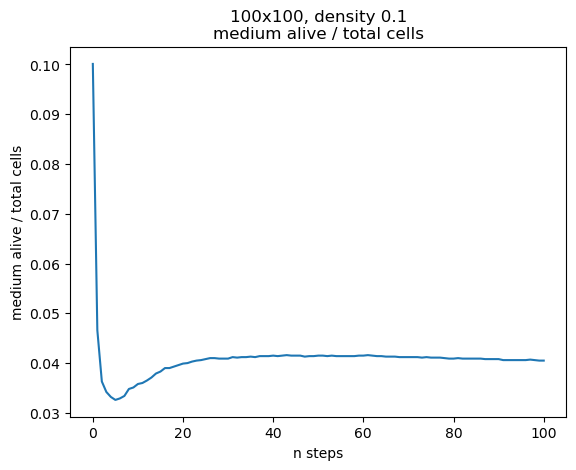

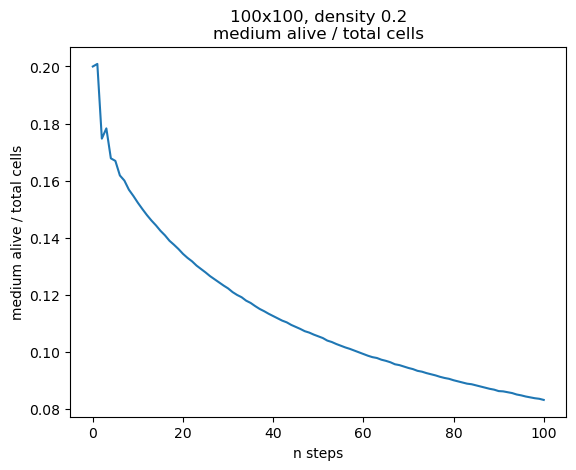

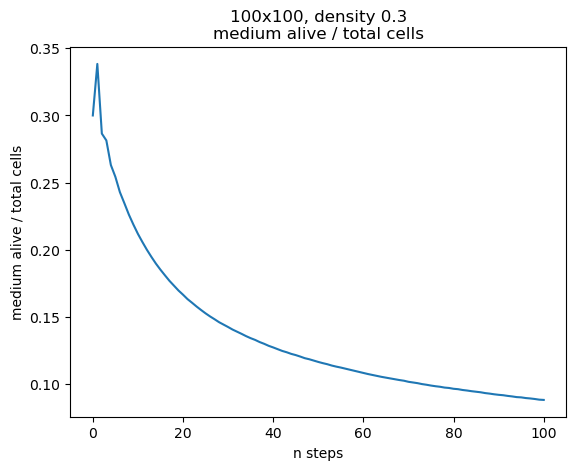

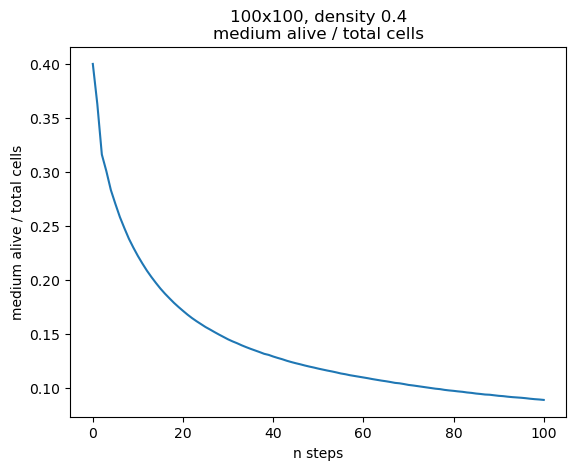

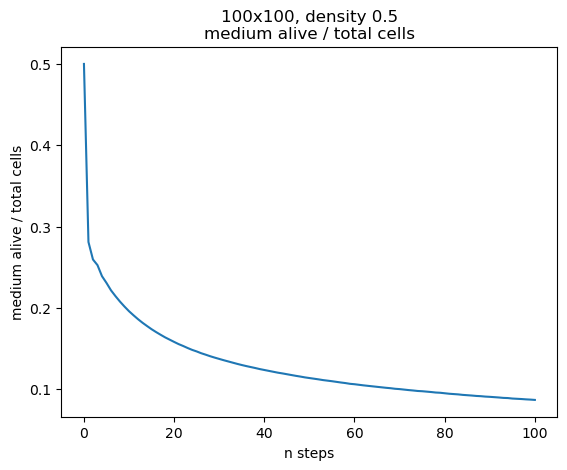

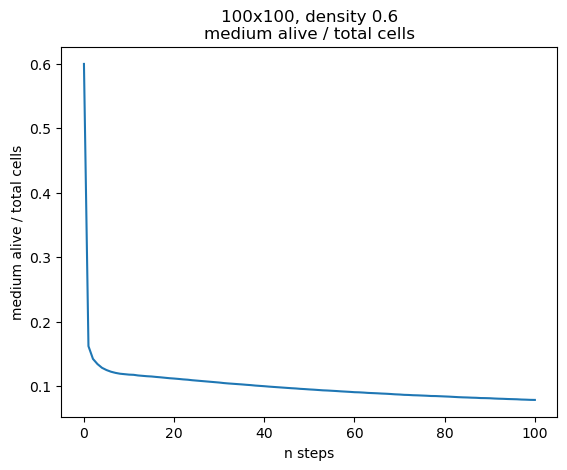

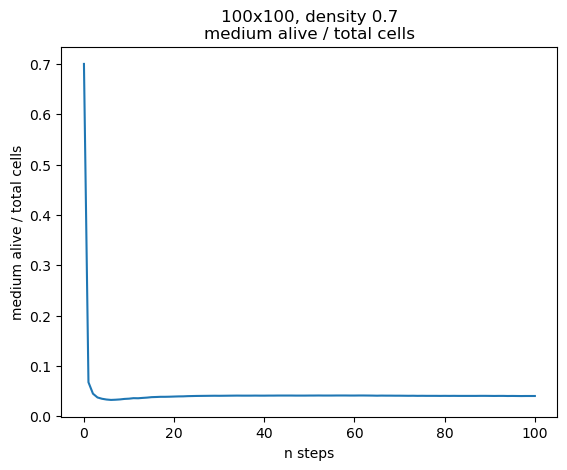

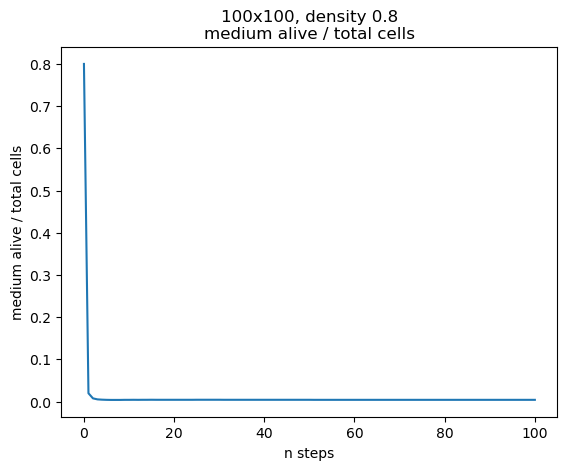

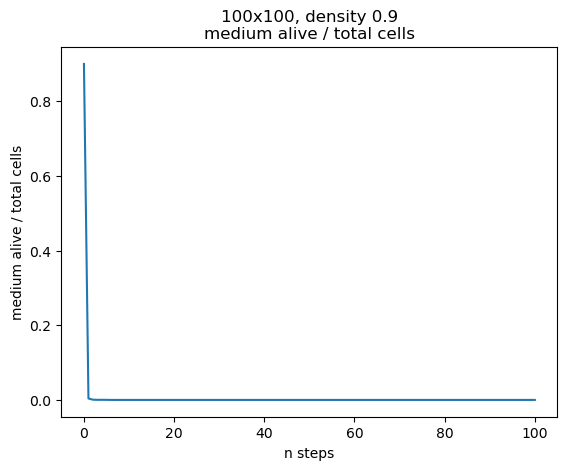

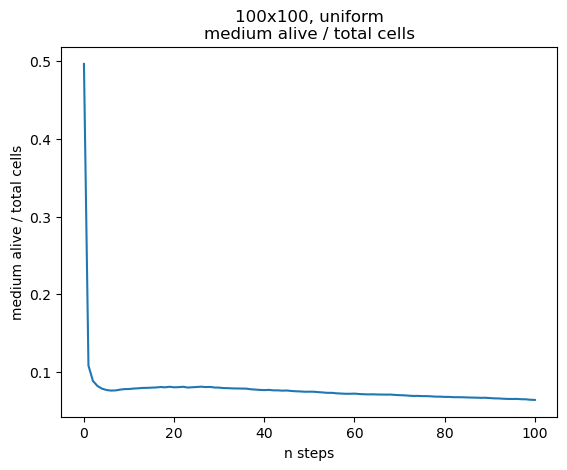

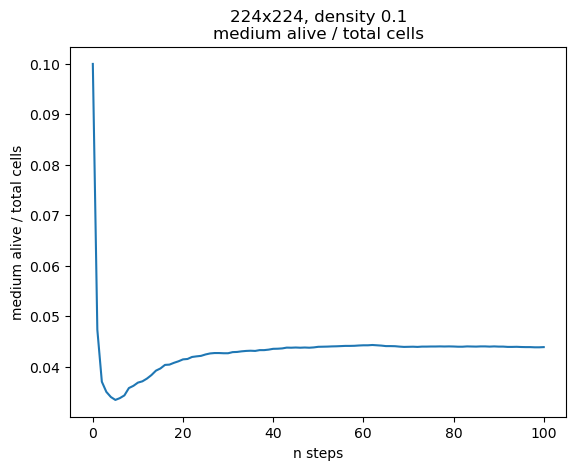

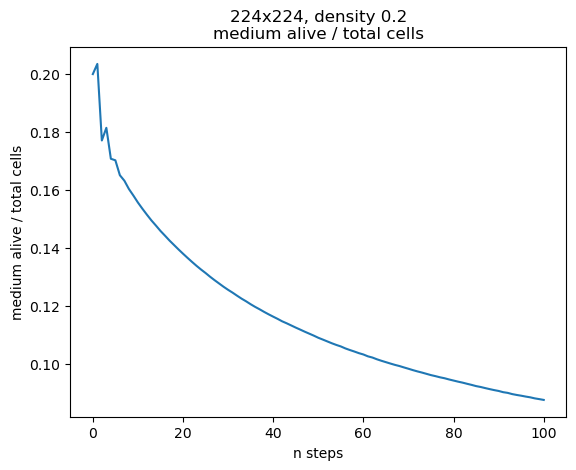

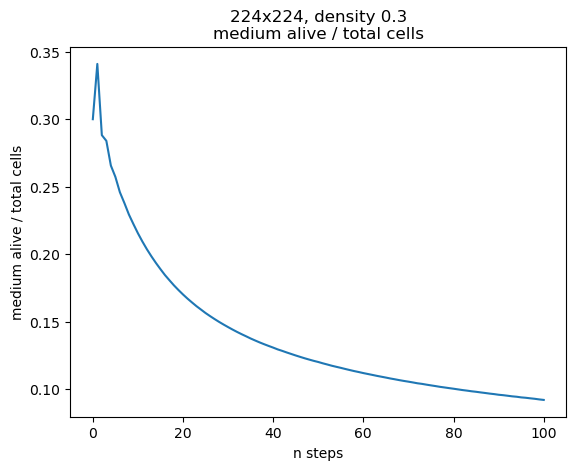

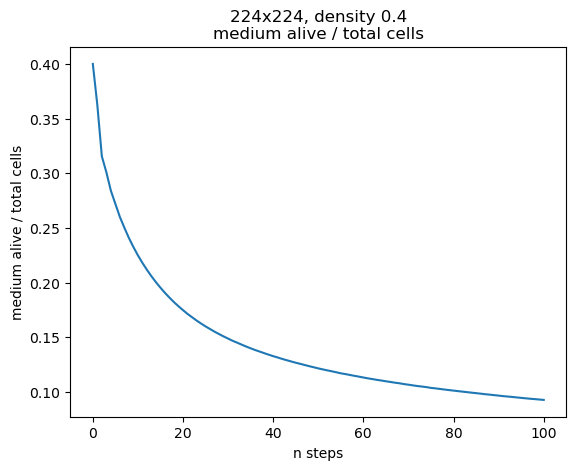

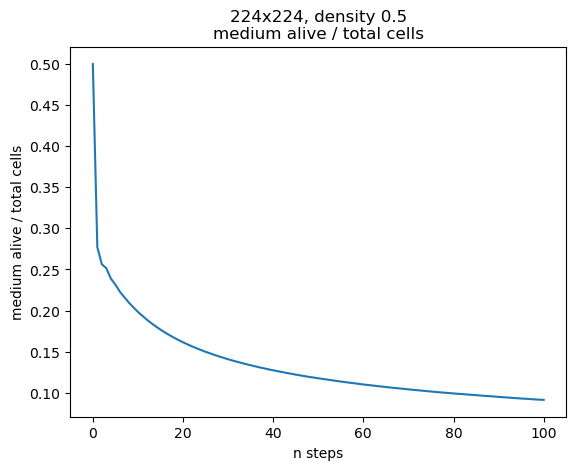

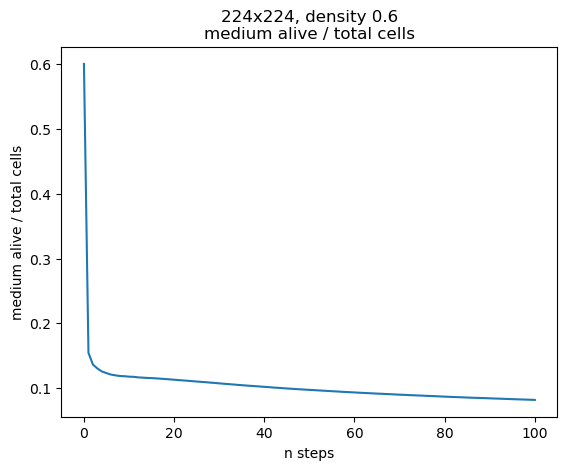

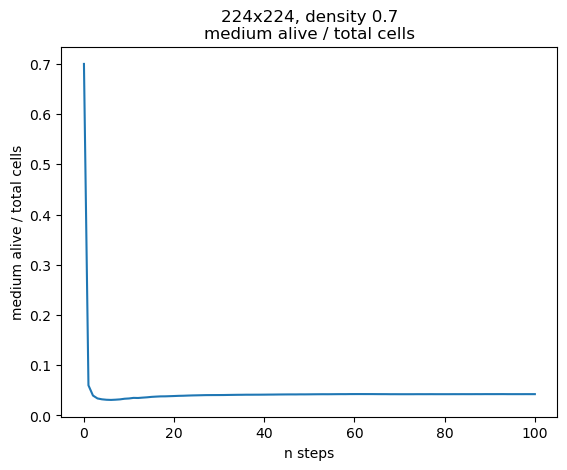

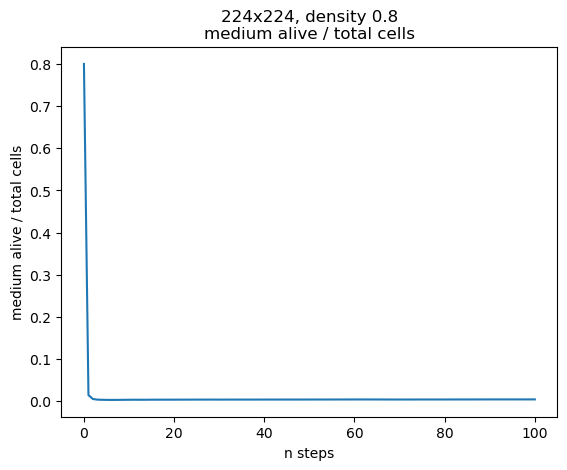

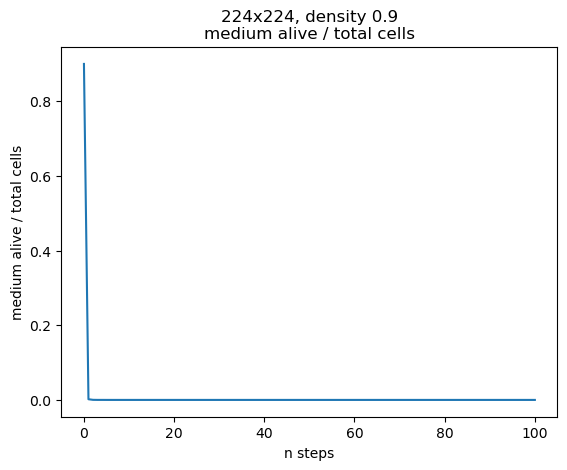

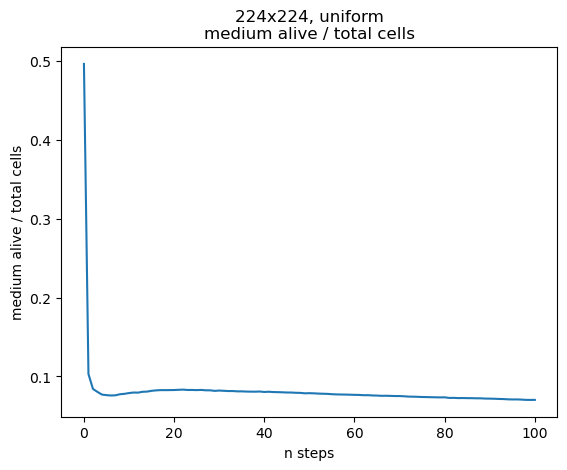

In [31]:
for i, size in enumerate(sizes):
    for j, generator_name in enumerate(generators.keys()):
        stat_name = 'medium alive / total cells'
        plt.figure()
        plt.title(f'{size[0]}x{size[1]}, {generator_name}\n{stat_name}')
        plt.plot(range(stats_norm.shape[2]), stats_norm[i,j,:,3])
        plt.xlabel('n steps')
        plt.ylabel(stat_name)
        plt.show()

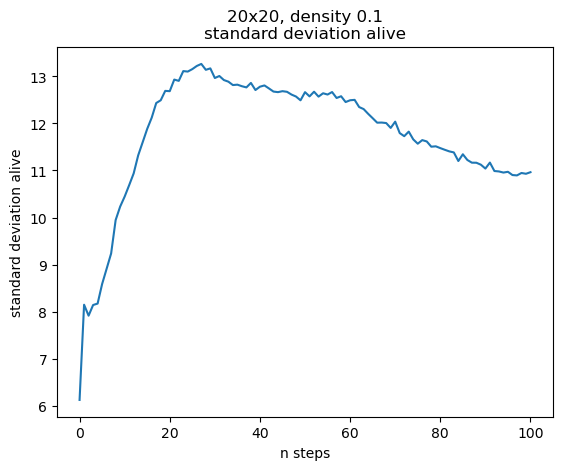

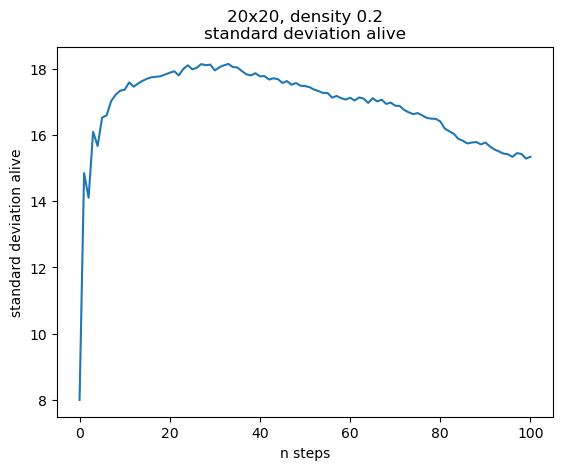

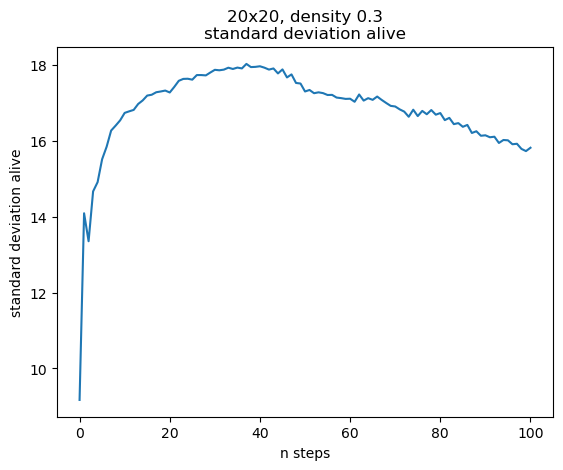

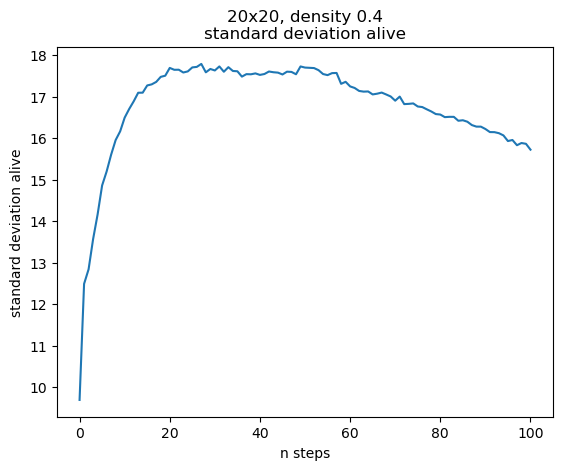

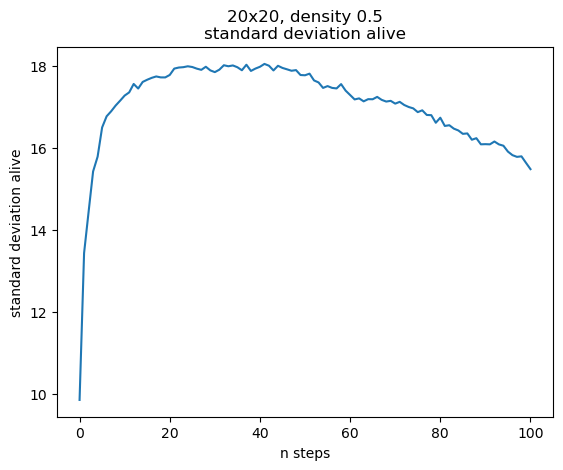

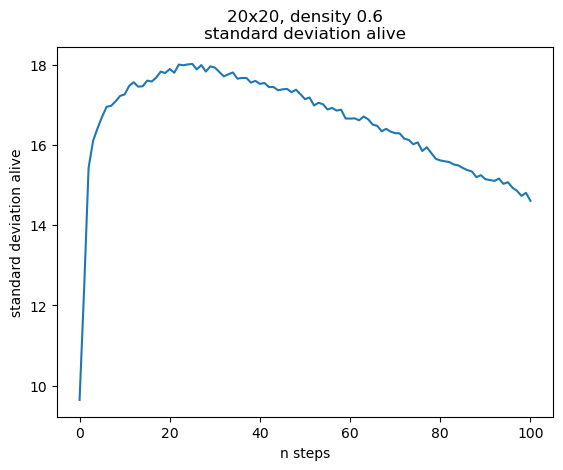

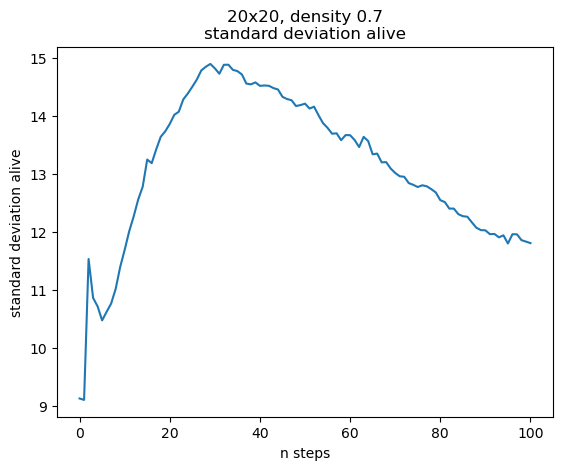

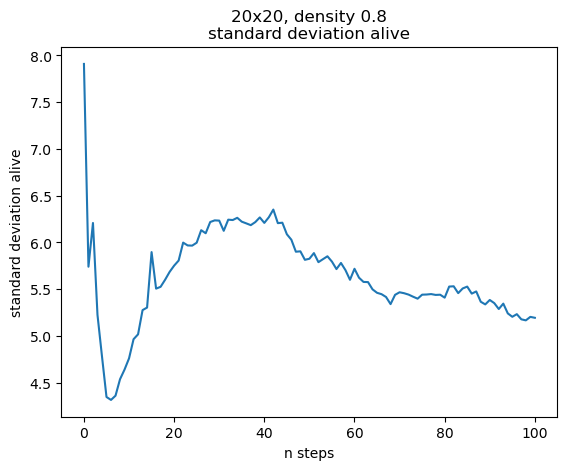

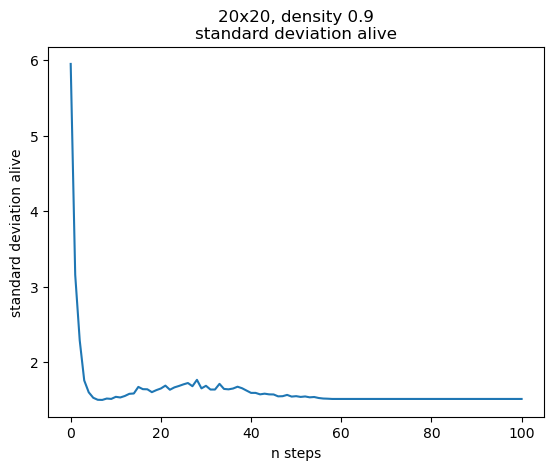

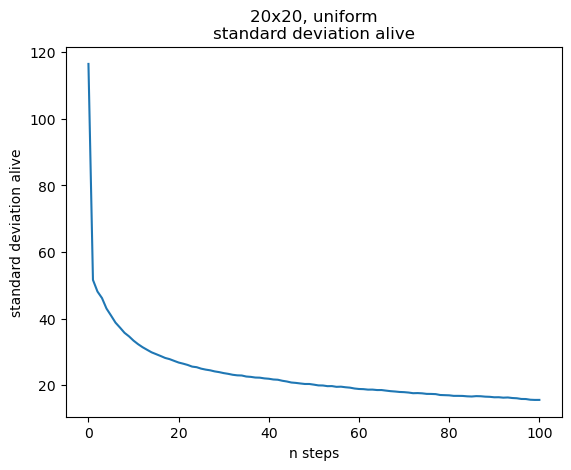

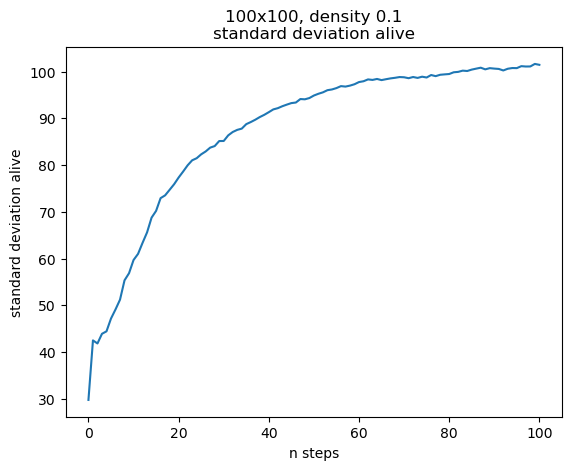

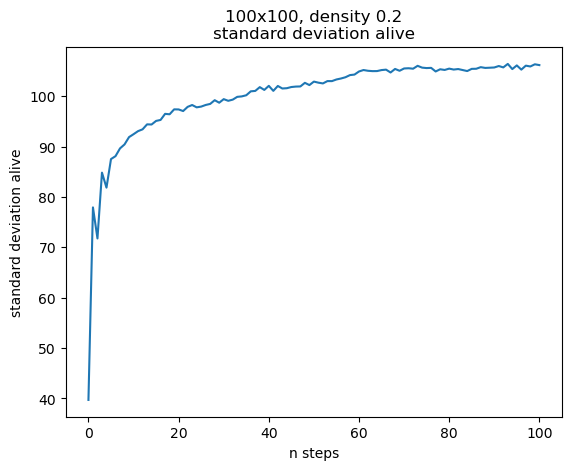

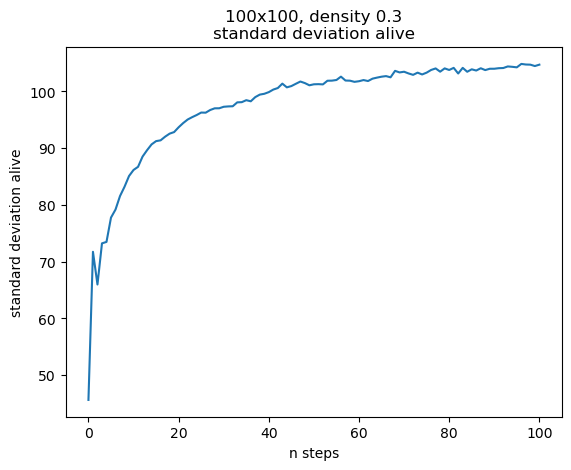

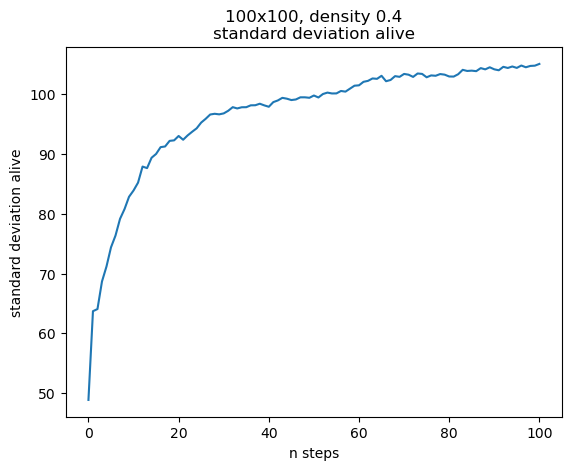

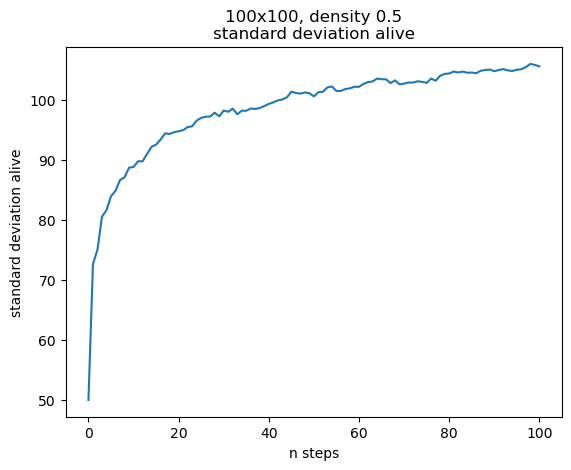

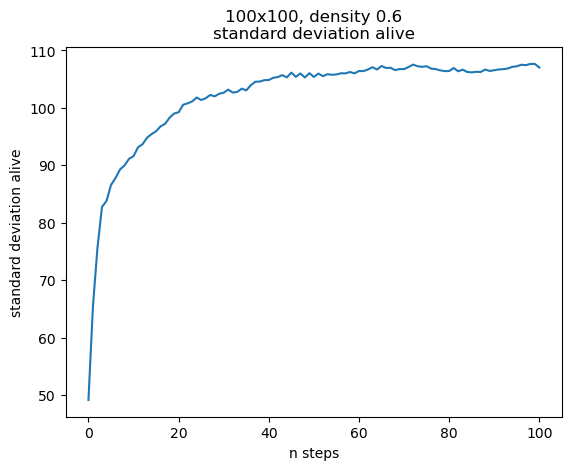

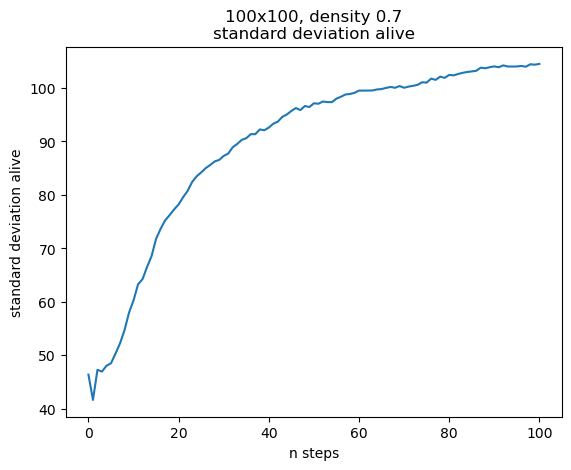

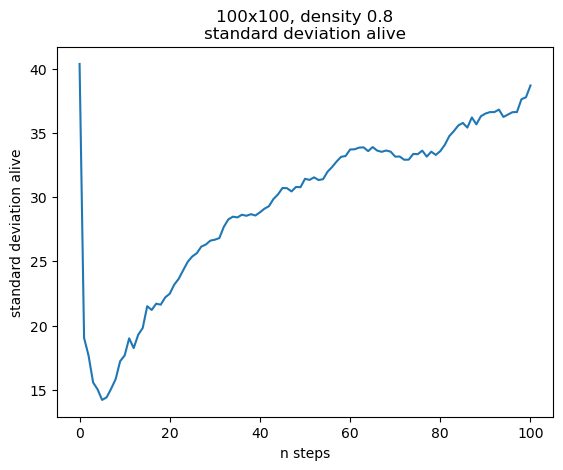

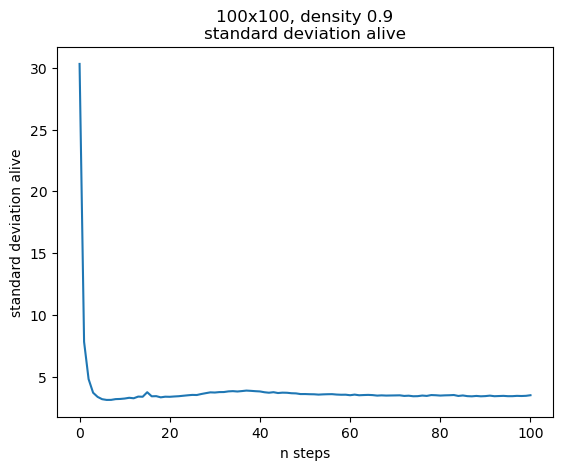

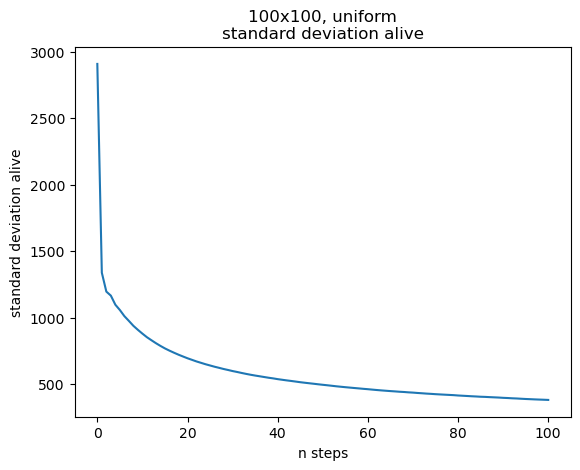

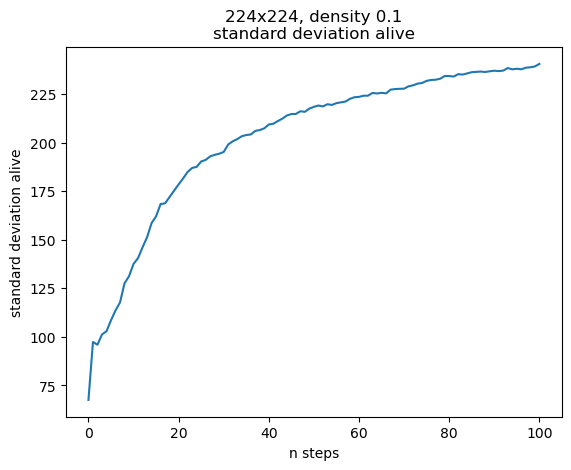

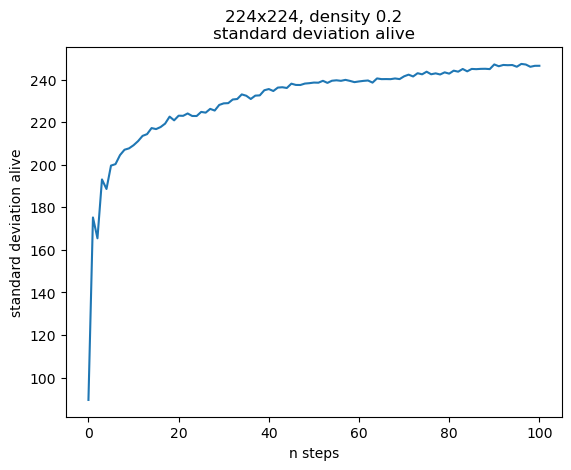

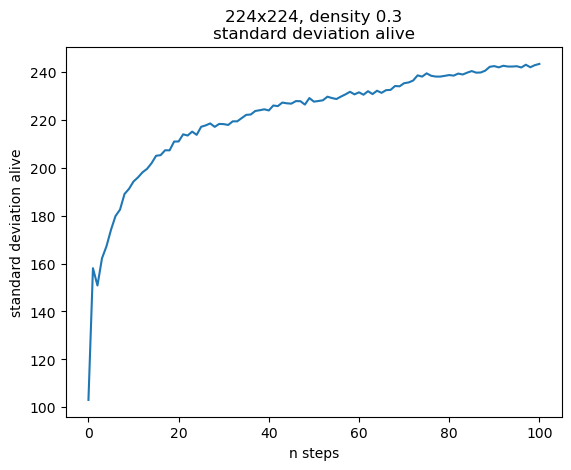

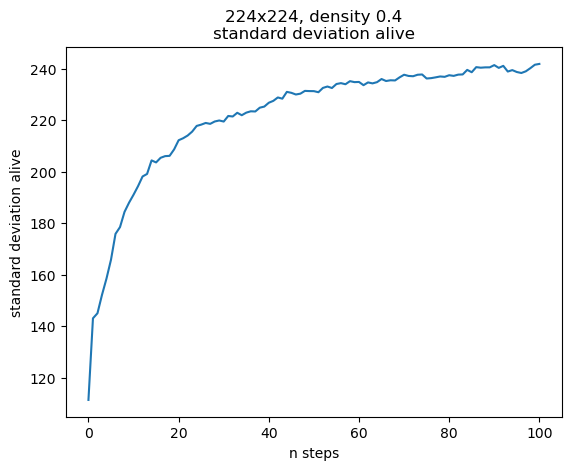

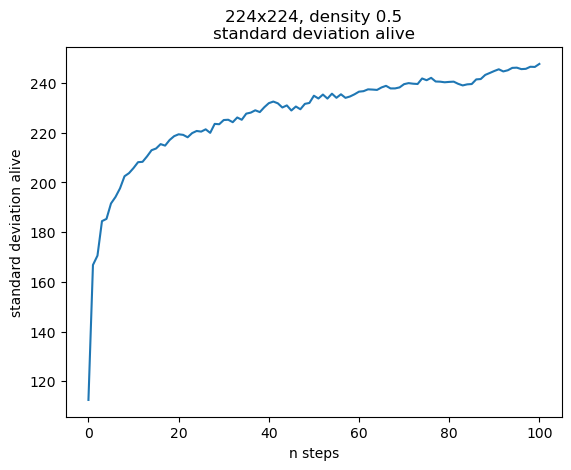

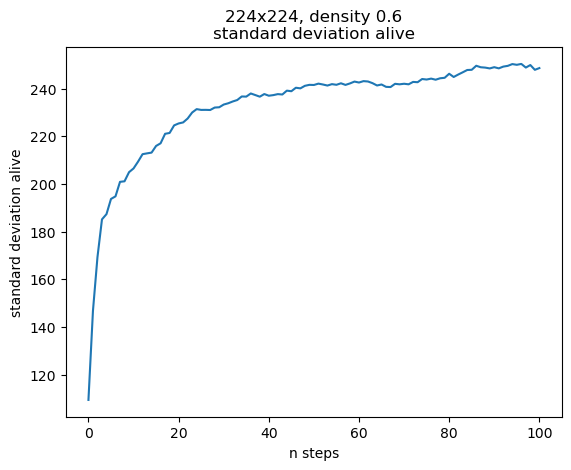

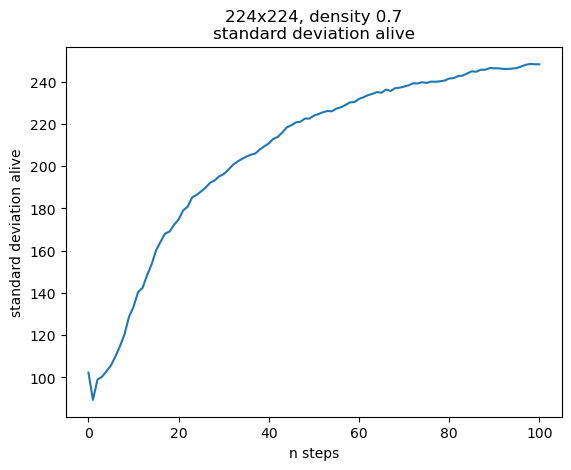

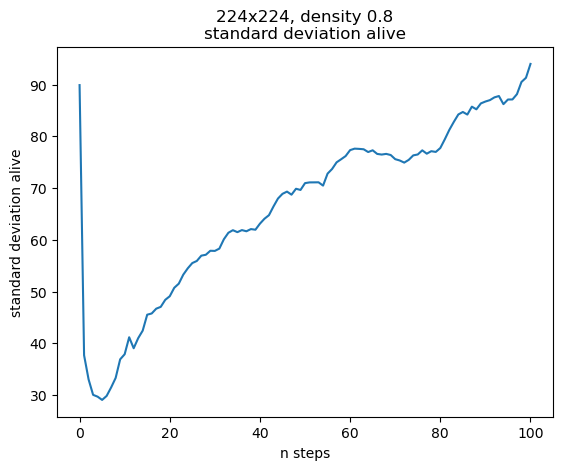

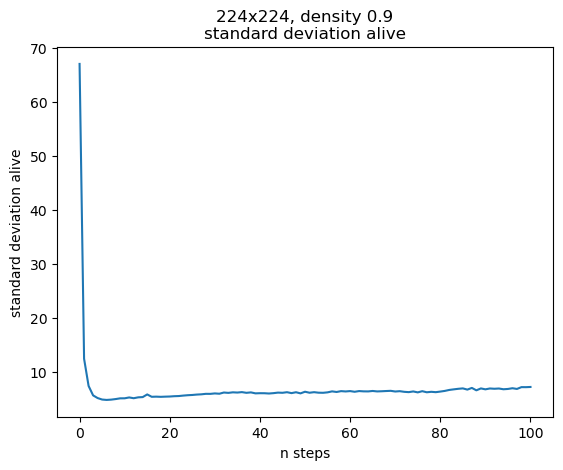

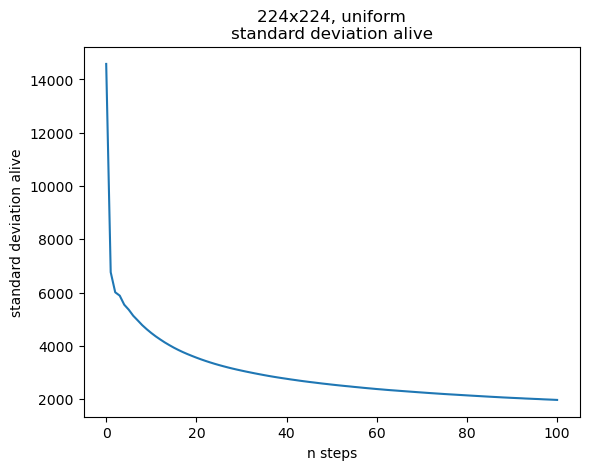

In [32]:
for i, size in enumerate(sizes):
    for j, generator_name in enumerate(generators.keys()):
        stat_name = 'standard deviation alive'
        plt.figure()
        plt.title(f'{size[0]}x{size[1]}, {generator_name}\n{stat_name}')
        plt.plot(range(stats_norm.shape[2]), stats_norm[i,j,:,4]**(1/2))
        plt.xlabel('n steps')
        plt.ylabel(stat_name)
        plt.show()